In [1]:
''' Load dependencies '''

### Elementary libraries
import pandas as pd
import numpy as np


### Graphic libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
import seaborn as sns
import missingno as msno
import plotly.graph_objects as go

### Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_curve, auc


### Some Scikit-learn utils
from sklearn.cluster import BisectingKMeans, KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

### Models
from xgboost import XGBClassifier, plot_importance
from sklearn.manifold import TSNE





### Some cosmetics and makeup add-ons
import warnings
# prevents numpy and pandas scientific/exponential notation on print, default is False
# force-suppressing the scientific notation, it is rounded and justified
#np.set_printoptions(suppress=True, formatter={'float_kind': '{:0.4f}'.format})
pd.options.display.float_format = '{:.4f}'.format
# ignoring warnings, suppressing/preventing/hushing up all warnings
warnings.filterwarnings(action='ignore')
sns.set_style("whitegrid")



In [2]:

''' 
 
this is an user-defined function: creating our own functions based on our requirements especially to reduce the coding
  
*args in Python (Non-Keyword Arguments): arbitrary keyword argument, *args can pass a variable number of arguments     
**kwargs in Python (Keyword Arguments): arbitrary keyword argument, **kargs can pass a variable number of arguments 
 
'''

def take_desired_interval(data: pd.DataFrame, start_date: pd.to_datetime, end_date: pd.to_datetime) -> pd.DataFrame:
    
    #print(f'\n')
    """ Filtered set of data based on the given period and performing custom feature scaling as well: """

    # body of the function
    df = pd.pivot_table( data.loc[(data['DateTime'] >= start_date) & (data['DateTime'] <= end_date)],
                         values='Amount',            # ['A', 'B']      
                         index='Client', 
                         columns='Top Category', 
                         aggfunc={'Amount': 'sum'},  # {'A':'sum', 'B':'mean'}
                         fill_value=0, 
                         margins=True, 
                         dropna=True, 
                         margins_name='total',  # All
                         observed=False, 
                         sort=True
                       )

    ''' 
    performing custom feature scaling
    '''

    for row in df.itertuples():
        df.at[row.Index, 'money'] = df.loc[row.Index, 'money'] / (df.loc[row.Index, 'total'])
        df.at[row.Index, 'self_realization'] = df.loc[row.Index, 'self_realization'] / (df.loc[row.Index, 'total'])
        df.at[row.Index, 'socialization'] = df.loc[row.Index, 'socialization'] / (df.loc[row.Index, 'total'])
        df.at[row.Index, 'survival'] = df.loc[row.Index, 'survival'] / (df.loc[row.Index, 'total'])


    ''' it means all rows except last one and all columns except the last column '''
    df = df.iloc[:-1, :-1]                

    return df

In [3]:
''' 
reading whole dataset from the given file and loading those data and save them in a DataFrame, named df_data

'''
df_data = pd.read_csv("/Users/USER/Desktop/2025 ITMO THESIS/transact_18_22.csv")
working_df = df_data.copy()   # make for security a copy of the original dataframe before further processing 

categories=['food', 'outfit', 'dwelling', 'health', 'beauty', 'remote', 'travel','money', 'kids', 'nonfood', 'telecom', 'fun', 'charity', 'misc']
working_df = working_df.loc[(working_df['group'].isin(categories))]


print(f'\n')
print("Number of rows before removing transactions less than 500 and duplications:", len(working_df))
working_df = working_df.loc[(working_df['amt'] > 500)]

print(f'\n')
print("Number of rows after removing transactions less than 500 and before removing duplications:", len(working_df))
working_df.drop_duplicates(keep=False, inplace=True)

print(f'\n')
print("Number of rows after removing transactions less than 500 and removing duplications:", len(working_df))


working_df.rename(columns = {'client':'Client', 'card':'Card', 'amt':'Amount', 'mcc':'MCC', 'group':'Category', 'value':'Top Category'}, inplace = True)

working_df['DateTime'] = pd.to_datetime(working_df['date'])

junky_fields = ['date']

working_df.drop(junky_fields, axis=1, inplace=True)


print(f'\n')
working_df



Number of rows before removing transactions less than 500 and duplications: 19026862


Number of rows after removing transactions less than 500 and before removing duplications: 8316331


Number of rows after removing transactions less than 500 and removing duplications: 8059496




,Client,Card,Amount,MCC,Category,Top Category,DateTime
0,390989,3048567,878.0000,5814,food,survival,2018-01-01
3,475694,2884069,2564.0000,5941,fun,self_realization,2018-01-01
5,2406107,3465449,909.3800,5411,food,survival,2018-01-01
7,2714314,3732417,1071.0000,5411,food,survival,2018-01-01
10,1356203,3823801,500.5000,5541,travel,socialization,2018-01-01
...,...,...,...,...,...,...,...
19262659,2936262,6378152,4000.0000,6011,money,money,2022-08-15
19262661,1529535,4825266,4766.7200,6536,money,money,2022-08-15
19262664,266552,6271909,3900.0000,6011,money,money,2022-08-15
19262666,2643664,6889520,5000.0000,6011,money,money,2022-08-15


## **2. Data manipulation**

In [4]:
''' 
the log transformation is often used to reduce skewness of a measurement variable, we use base 10 because we have 10 fingers )))
in base 10, ten digits are used and those digits are 0 through 9.
skewness ~ is a measure of the asymmetry of a distribution
           a zero skew means the data graph is symmetrical and reveals a normal data distribution regardless of how long or fat the distribution tails are
           if skewness is between -0.5 and 0.5, the distribution is approximately symmetric

'''

working_df['Amount_L10'] = np.log10(working_df['Amount']).astype(float) # np.log10(working_df['Amount']).round().astype(int)

working_df.head(10)

,Client,Card,Amount,MCC,Category,Top Category,DateTime,Amount_L10
0,390989,3048567,878.0000,5814,food,survival,2018-01-01,2.9435
3,475694,2884069,2564.0000,5941,fun,self_realization,2018-01-01,3.4089
5,2406107,3465449,909.3800,5411,food,survival,2018-01-01,2.9587
7,2714314,3732417,1071.0000,5411,food,survival,2018-01-01,3.0298
10,1356203,3823801,500.5000,5541,travel,socialization,2018-01-01,2.6994
11,316576,3008238,1015.3000,5411,food,survival,2018-01-01,3.0066
15,1382058,2415606,715.0000,5411,food,survival,2018-01-01,2.8543
16,2889080,2337144,779.5000,5411,food,survival,2018-01-01,2.8918
17,2454592,3463684,519.0300,5411,food,survival,2018-01-01,2.7152
18,2866255,3737744,2900.0000,6011,money,money,2018-01-01,3.4624


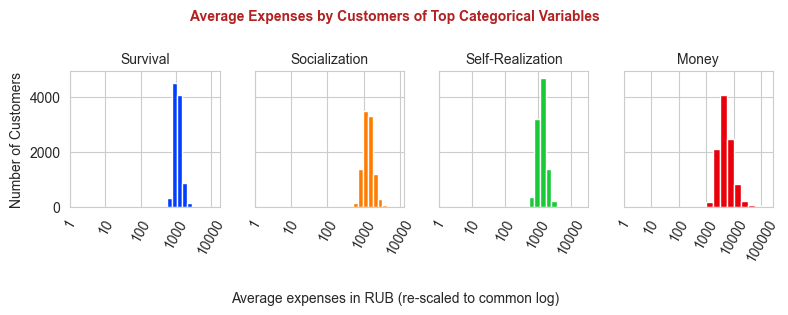

In [5]:
''' returns series '''

gr_by_client_survival = working_df.loc[working_df['Top Category'] == 'survival'].groupby( by = ['Client'], 
                                                                                  axis=0, 
                                                                                  level=None,
                                                                                  as_index=True, 
                                                                                  sort=True, 
                                                                                  group_keys=True, 
                                                                                  observed=False, 
                                                                                  dropna=True)['Amount_L10'].mean()

gr_by_client_socialization = working_df.loc[working_df['Top Category'] == 'socialization'].groupby( by = ['Client'], 
                                                                                  axis=0, 
                                                                                  level=None,
                                                                                  as_index=True, 
                                                                                  sort=True, 
                                                                                  group_keys=True, 
                                                                                  observed=False, 
                                                                                  dropna=True)['Amount_L10'].mean()


gr_by_client_self_realization = working_df.loc[working_df['Top Category'] == 'self_realization'].groupby( by = ['Client'], 
                                                                                  axis=0, 
                                                                                  level=None,
                                                                                  as_index=True, 
                                                                                  sort=True, 
                                                                                  group_keys=True, 
                                                                                  observed=False, 
                                                                                  dropna=True)['Amount_L10'].mean()

gr_by_client_money = working_df.loc[working_df['Top Category'] == 'money'].groupby( by = ['Client'], 
                                                                                  axis=0, 
                                                                                  level=None,
                                                                                  as_index=True, 
                                                                                  sort=True, 
                                                                                  group_keys=True, 
                                                                                  observed=False, 
                                                                                  dropna=True)['Amount_L10'].mean()



''' plotting the graph '''
colors = sns.color_palette(palette = 'bright', n_colors = 4,)

fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, tight_layout=True, figsize=(8, 3))
plt.subplot(141)
plt.hist(gr_by_client_survival, bins=10, color = colors[0])
x=np.arange(max(gr_by_client_survival))
plt.xticks(x, (10**x).astype(int), rotation=60)
plt.ylabel('Number of Customers', fontsize = 10)
#plt.xlabel('Average daily expenses', fontsize = 9)
plt.title('Survival', fontsize = 10)

plt.subplot(142)
plt.hist(gr_by_client_socialization, bins=10, color = colors[1])
x=np.arange(max(gr_by_client_socialization))
plt.xticks(x, (10**x).astype(int), rotation=60)
#plt.xlabel('Average daily expenses', fontsize = 9)
plt.title('Socialization', fontsize = 10)

plt.subplot(143)
plt.hist(gr_by_client_self_realization, bins=10, color = colors[2])
x=np.arange(max(gr_by_client_self_realization))
plt.xticks(x, (10**x).astype(int), rotation=60)
#plt.xlabel('Average daily expenses', fontsize = 9)
plt.title('Self-Realization', fontsize = 10)

plt.subplot(144)  
plt.hist(gr_by_client_money, bins=10, color = colors[3])
x=np.arange(max(gr_by_client_money))
plt.xticks(x, (10**x).astype(int), rotation=60)
#plt.xlabel('Average daily expenses', fontsize = 9)
plt.title('Money', fontsize = 10)

fig.suptitle("Average Expenses by Customers of Top Categorical Variables", fontsize = 10, fontweight = 'bold', color = 'firebrick', y = 0.995)
fig.supxlabel('Average expenses in RUB (re-scaled to common log)', fontsize = 10)
#plt.savefig('Average_Distribution_of_Relativity_of_Top_Categorical_Variables.png', dpi=600, pad_inches=0.1, facecolor='white') 
fig.tight_layout()
fig.show()



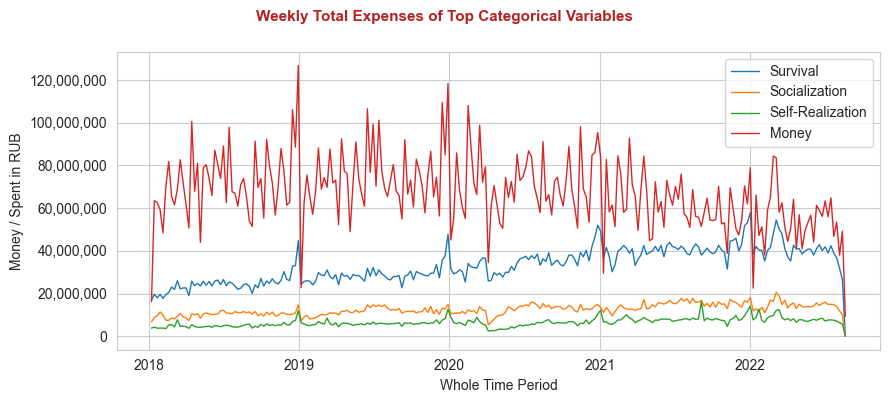

In [6]:
''' 
creating a pivot table using pandas pivot_table function is a process of grouping, summarising, aggregating,
and calculating statistics about the specified data in a DataFrame

filtering based on week, as a result, acquire the subset of data, the filtered DataFrame

'''

wdf_weekly_pivoted = pd.pivot_table( working_df, 
                                     values='Amount',            # ['A', 'B']       
                                     index=pd.Grouper(freq='W', key='DateTime'), 
                                     columns='Top Category', 
                                     aggfunc={'Amount': 'sum'},  # {'A':'sum', 'B':'mean'}
                                     fill_value=None, 
                                     margins=False, 
                                     dropna=True, 
                                     margins_name='All',  # Total
                                     observed=False, 
                                     sort=True
                                    )
#wdf_weekly_pivoted.head(5)

fig, ax = plt.subplots(figsize = (9, 4))
sns.lineplot(data=wdf_weekly_pivoted, y=wdf_weekly_pivoted['survival'], x=wdf_weekly_pivoted.index, palette="nipy_spectral", linewidth=1, ax=ax, label='Survival')
sns.lineplot(data=wdf_weekly_pivoted, y=wdf_weekly_pivoted['socialization'], x=wdf_weekly_pivoted.index, palette="nipy_spectral", linewidth=1, ax=ax, label='Socialization')
sns.lineplot(data=wdf_weekly_pivoted, y=wdf_weekly_pivoted['self_realization'], x=wdf_weekly_pivoted.index, palette="nipy_spectral", linewidth=1, ax=ax, label='Self-Realization')
sns.lineplot(data=wdf_weekly_pivoted, y=wdf_weekly_pivoted['money'], x=wdf_weekly_pivoted.index, palette="nipy_spectral", linewidth=1, ax=ax, label='Money')
ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('Whole Time Period', fontsize=10)
ax.set_ylabel('Money / Spent in RUB', fontsize=10)

fig.suptitle('Weekly Total Expenses of Top Categorical Variables', fontsize = 11, fontweight = 'bold', color = 'firebrick', y = 0.995)
#plt.savefig('Weekly_Total_ExpensesofTop_Categorical_Variables.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()



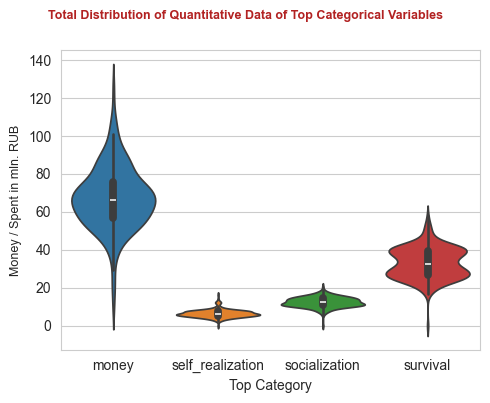

In [7]:
''' pd.DataFrame creates index by default '''

temp = pd.DataFrame(wdf_weekly_pivoted.stack())

''' removing indexes from the temp dataframe and renaming the 0 column '''

temp = temp.reset_index() 

temp.rename(columns = {0:'Amount'}, inplace = True)

'''
   violinplot draws a combination of boxplot and kernel density estimate. It plays a similar role as a box and whisker plot. 
   It shows the distribution of quantitative data across several levels of one (or more) categorical variables such that those distributions can be compared. 
   It features a kernel density estimation of the underlying distribution. This can be an effective and attractive way to show multiple distributions 
   of data at once, but we keep in mind that the estimation procedure is influenced by the sample size.
 
'''

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 4))

sns.violinplot(data = temp, x = 'Top Category', y = temp['Amount'].astype(float)/1e6, hue='Top Category')
ax.set_ylabel('Money / Spent in mln. RUB', fontsize = 9)
 
fig.suptitle('Total Distribution of Quantitative Data of Top Categorical Variables', fontsize = 9, fontweight = 'bold', color = 'firebrick', y = 0.995)
#plt.savefig('Total_Distribution_of_Quantitative_Data_of_Top_Categorical_Variables.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout() 
fig.show()


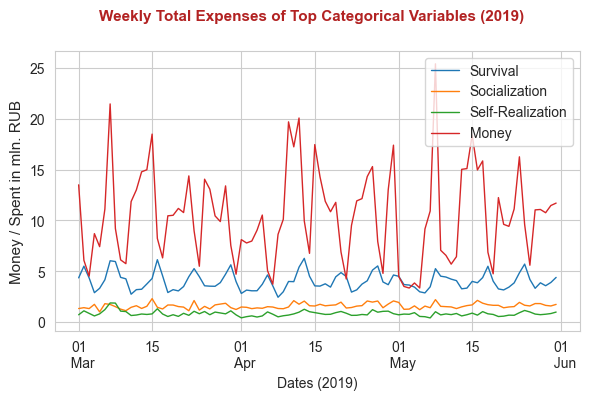

In [8]:

''' 
creating a pivot table using pandas pivot_table function is a process of grouping, summarising, aggregating,
and calculating statistics about the specified data in a DataFrame

filtering based on week, as a result, acquire the subset of data, the filtered DataFrame

'''

wdf_weekly_zoomed2019_pivoted = pd.pivot_table( working_df.loc[(working_df['DateTime'] >= '2019-03-01') & (working_df['DateTime'] <= '2019-05-31')], # filtering working_df based on date interval 
                            values='Amount',           
                            index=pd.Grouper(freq='D', key='DateTime'), 
                            columns='Top Category', 
                            aggfunc={'Amount': 'sum'},  
                            fill_value=0, 
                            margins=False, 
                            dropna=True, 
                            margins_name='All', 
                            observed=False, 
                            sort=True
                            )

data = wdf_weekly_zoomed2019_pivoted 
data = data.reset_index()


fig, ax = plt.subplots(figsize = (6, 4))
sns.lineplot(data=data, y=data['survival'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax = ax, label='Survival')
sns.lineplot(data=data, y=data['socialization'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax=ax, label='Socialization')
sns.lineplot(data=data, y=data['self_realization'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax=ax, label='Self-Realization')
sns.lineplot(data=data, y=data['money'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax=ax, label='Money')

''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days:
sec = ax.secondary_xaxis(location = -0.075) # label the months:
sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
# note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
sec.tick_params('x', length=0)
sec.spines['bottom'].set_linewidth(0)
sec.set_xlabel('Dates (2019)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis

ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('')
ax.set_ylabel('Money / Spent in mln. RUB', fontsize=11)


fig.suptitle('        Weekly Total Expenses of Top Categorical Variables (2019)', fontsize = 11, fontweight = 'bold', color = 'firebrick', y = 0.995)
#plt.savefig('Weekly_Total_Expenses_of_Top_Categorical_Variables_and_Correlation_Heatmap_2019.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

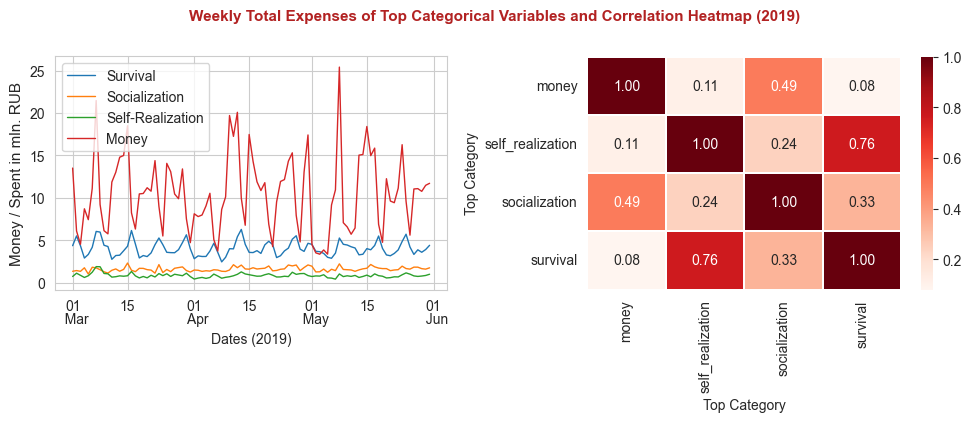

In [9]:

''' 
creating a pivot table using pandas pivot_table function is a process of grouping, summarising, aggregating,
and calculating statistics about the specified data in a DataFrame

filtering based on week, as a result, acquire the subset of data, the filtered DataFrame

'''

wdf_weekly_zoomed2019_pivoted = pd.pivot_table( working_df.loc[(working_df['DateTime'] >= '2019-03-01') & (working_df['DateTime'] <= '2019-05-31')], # filtering working_df based on date interval 
                            values='Amount',           
                            index=pd.Grouper(freq='D', key='DateTime'), 
                            columns='Top Category', 
                            aggfunc={'Amount': 'sum'},  
                            fill_value=0, 
                            margins=False, 
                            dropna=True, 
                            margins_name='All', 
                            observed=False, 
                            sort=True
                            )

data = wdf_weekly_zoomed2019_pivoted 
data = data.reset_index()


fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4.2))
ax = ax.flat
for i in range(0, 2, 1):
    if i == 0:
        sns.lineplot(data=data, y=data['survival'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax = ax[i], label='Survival')
        sns.lineplot(data=data, y=data['socialization'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax=ax[i], label='Socialization')
        sns.lineplot(data=data, y=data['self_realization'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax=ax[i], label='Self-Realization')
        sns.lineplot(data=data, y=data['money'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax=ax[i], label='Money')

        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days:
        sec = ax[i].secondary_xaxis(location = -0.075) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        sec.set_xlabel('Dates (2019)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis

        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('Money / Spent in mln. RUB', fontsize=11)
    else:
        sns.heatmap(round(data.corr(), 2), annot=True, ax=ax[i], cmap="Reds", fmt='.2f', linewidths=.03)
        fig.subplots_adjust(top=0.90)   

fig.suptitle('Weekly Total Expenses of Top Categorical Variables and Correlation Heatmap (2019)', fontsize = 11, fontweight = 'bold', color = 'firebrick', y = 0.995)
#plt.savefig('Weekly_Total_Expenses_of_Top_Categorical_Variables_and_Correlation_Heatmap_2019.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

It can be seen that there is highly positive correlation between self_realization and survival attributes. 

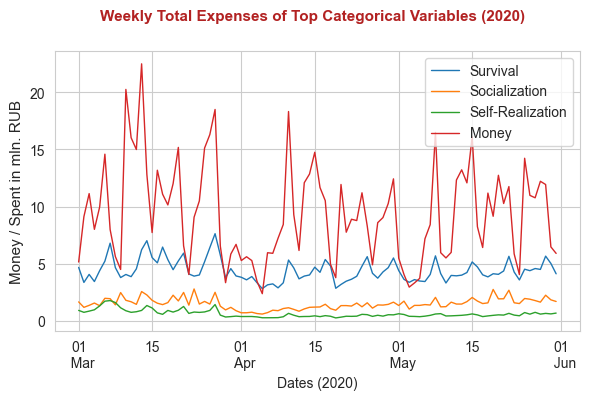

In [10]:

''' 
creating a pivot table using pandas pivot_table function is a process of grouping, summarising, aggregating,
and calculating statistics about the specified data in a DataFrame

filtering based on week, as a result, acquire the subset of data, the filtered DataFrame

'''

wdf_weekly_zoomed2020_pivoted = pd.pivot_table( working_df.loc[(working_df['DateTime'] >= '2020-03-01') & (working_df['DateTime'] <= '2020-05-31')], 
                                    values='Amount',           
                                    index=pd.Grouper(freq='D', key='DateTime'), 
                                    columns='Top Category', 
                                    aggfunc={'Amount': 'sum'},  
                                    fill_value=0, 
                                    margins=False, 
                                    dropna=True, 
                                    margins_name='All', 
                                    observed=False, 
                                    sort=True
                                    )

data = wdf_weekly_zoomed2020_pivoted 
data = data.reset_index()


fig, ax = plt.subplots(figsize = (6, 4))

sns.lineplot(data=data, y=data['survival'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax = ax, label='Survival')
sns.lineplot(data=data, y=data['socialization'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax=ax, label='Socialization')
sns.lineplot(data=data, y=data['self_realization'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax=ax, label='Self-Realization')
sns.lineplot(data=data, y=data['money'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax=ax, label='Money')

''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days:
sec = ax.secondary_xaxis(location = -0.075) # label the months:
sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
# note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
sec.tick_params('x', length=0)
sec.spines['bottom'].set_linewidth(0)
sec.set_xlabel('Dates (2020)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
sns.move_legend(ax, loc='upper right')
ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('')
ax.set_ylabel('Money / Spent in mln. RUB', fontsize=11)

fig.suptitle('        Weekly Total Expenses of Top Categorical Variables (2020)', fontsize = 11, fontweight = 'bold', color = 'firebrick', y = 0.995)
#plt.savefig('Weekly_Total_Expenses_of_Top_Categorical_Variables_and_Correlation_Heatmap_2020.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

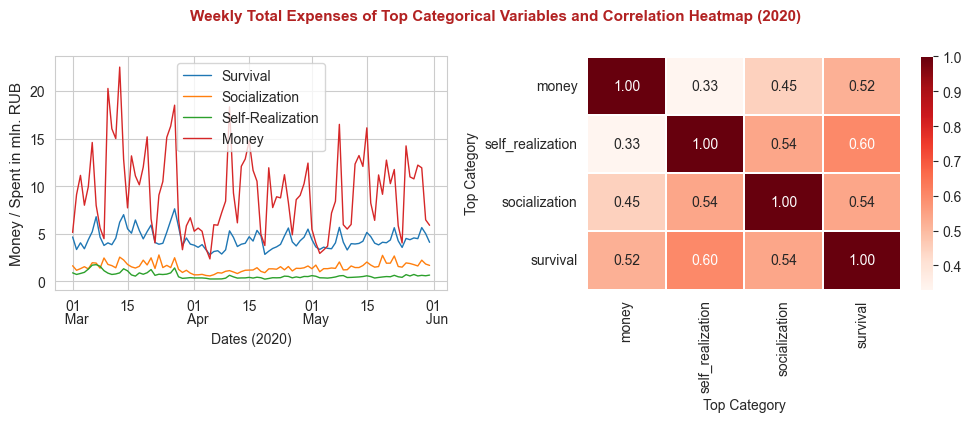

In [11]:

''' 
creating a pivot table using pandas pivot_table function is a process of grouping, summarising, aggregating,
and calculating statistics about the specified data in a DataFrame

filtering based on week, as a result, acquire the subset of data, the filtered DataFrame

'''

wdf_weekly_zoomed2020_pivoted = pd.pivot_table( working_df.loc[(working_df['DateTime'] >= '2020-03-01') & (working_df['DateTime'] <= '2020-05-31')], 
                                    values='Amount',           
                                    index=pd.Grouper(freq='D', key='DateTime'), 
                                    columns='Top Category', 
                                    aggfunc={'Amount': 'sum'},  
                                    fill_value=0, 
                                    margins=False, 
                                    dropna=True, 
                                    margins_name='All', 
                                    observed=False, 
                                    sort=True
                                    )

data = wdf_weekly_zoomed2020_pivoted 
data = data.reset_index()


fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4.2))
ax = ax.flat
for i in range(0, 2, 1):
    if i == 0:
        sns.lineplot(data=data, y=data['survival'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax = ax[i], label='Survival')
        sns.lineplot(data=data, y=data['socialization'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax=ax[i], label='Socialization')
        sns.lineplot(data=data, y=data['self_realization'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax=ax[i], label='Self-Realization')
        sns.lineplot(data=data, y=data['money'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax=ax[i], label='Money')

        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days:
        sec = ax[i].secondary_xaxis(location = -0.075) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        sec.set_xlabel('Dates (2020)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis

        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('Money / Spent in mln. RUB', fontsize=11)
    else:
        sns.heatmap(round(data.corr(), 2), annot=True, ax=ax[i], cmap="Reds", fmt='.2f', linewidths=.03)
        fig.subplots_adjust(top=0.90)   

fig.suptitle('Weekly Total Expenses of Top Categorical Variables and Correlation Heatmap (2020)', fontsize = 11, fontweight = 'bold', color = 'firebrick', y = 0.995)
#plt.savefig('Weekly_Total_Expenses_of_Top_Categorical_Variables_and_Correlation_Heatmap_2020.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

It can be seen that there is not so highly positive correlation between self_realization and survival attributes. 

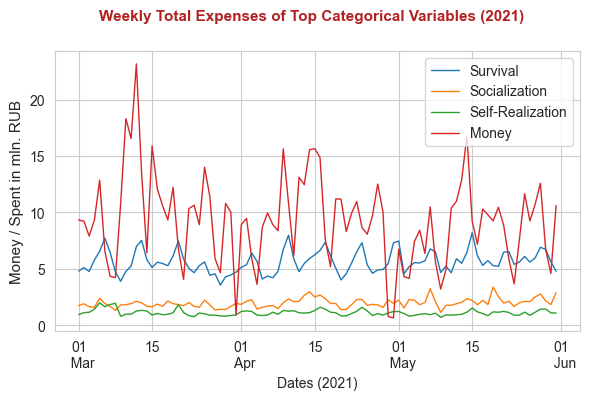

In [12]:
''' 
creating a pivot table using pandas pivot_table function is a process of grouping, summarising, aggregating,
and calculating statistics about the specified data in a DataFrame

filtering based on week, as a result, acquire the subset of data, the filtered DataFrame

'''

wdf_weekly_zoomed2022_pivoted = pd.pivot_table( working_df.loc[(working_df['DateTime'] >= '2021-03-01') & (working_df['DateTime'] <= '2021-05-31')], 
                                    values='Amount',           
                                    index=pd.Grouper(freq='D', key='DateTime'), 
                                    columns='Top Category', 
                                    aggfunc={'Amount': 'sum'},  
                                    fill_value=0, 
                                    margins=False, 
                                    dropna=True, 
                                    margins_name='All', 
                                    observed=False, 
                                    sort=True
                                    )

data = wdf_weekly_zoomed2022_pivoted 
data = data.reset_index()


fig, ax = plt.subplots(figsize = (6, 4))

sns.lineplot(data=data, y=data['survival'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax = ax, label='Survival')
sns.lineplot(data=data, y=data['socialization'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax=ax, label='Socialization')
sns.lineplot(data=data, y=data['self_realization'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax=ax, label='Self-Realization')
sns.lineplot(data=data, y=data['money'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax=ax, label='Money')

''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days:
sec = ax.secondary_xaxis(location = -0.075) # label the months:
sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
# note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
sec.tick_params('x', length=0)
sec.spines['bottom'].set_linewidth(0)
sec.set_xlabel('Dates (2021)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
sns.move_legend(ax, loc='upper right')
ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('')
ax.set_ylabel('Money / Spent in mln. RUB', fontsize=11)
 

fig.suptitle('        Weekly Total Expenses of Top Categorical Variables (2021)', fontsize = 11, fontweight = 'bold', color = 'firebrick', y = 0.995)
#plt.savefig('Weekly_Total_Expenses_of_Top_Categorical_Variables_and_Correlation_Heatmap_2022.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

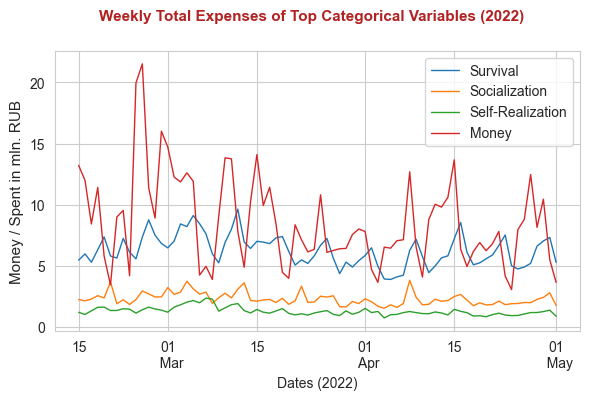

In [13]:

''' 
creating a pivot table using pandas pivot_table function is a process of grouping, summarising, aggregating,
and calculating statistics about the specified data in a DataFrame

filtering based on week, as a result, acquire the subset of data, the filtered DataFrame

'''

wdf_weekly_zoomed2022_pivoted = pd.pivot_table( working_df.loc[(working_df['DateTime'] >= '2022-02-15') & (working_df['DateTime'] <= '2022-05-01')], 
                                    values='Amount',           
                                    index=pd.Grouper(freq='D', key='DateTime'), 
                                    columns='Top Category', 
                                    aggfunc={'Amount': 'sum'},  
                                    fill_value=0, 
                                    margins=False, 
                                    dropna=True, 
                                    margins_name='All', 
                                    observed=False, 
                                    sort=True
                                    )

data = wdf_weekly_zoomed2022_pivoted 
data = data.reset_index()


fig, ax = plt.subplots(figsize = (6, 4))

sns.lineplot(data=data, y=data['survival'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax = ax, label='Survival')
sns.lineplot(data=data, y=data['socialization'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax=ax, label='Socialization')
sns.lineplot(data=data, y=data['self_realization'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax=ax, label='Self-Realization')
sns.lineplot(data=data, y=data['money'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax=ax, label='Money')

''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days:
sec = ax.secondary_xaxis(location = -0.075) # label the months:
sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
# note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
sec.tick_params('x', length=0)
sec.spines['bottom'].set_linewidth(0)
sec.set_xlabel('Dates (2022)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis

ax.get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('')
ax.set_ylabel('Money / Spent in mln. RUB', fontsize=11)
 

fig.suptitle('        Weekly Total Expenses of Top Categorical Variables (2022)', fontsize = 11, fontweight = 'bold', color = 'firebrick', y = 0.995)
#plt.savefig('Weekly_Total_Expenses_of_Top_Categorical_Variables_and_Correlation_Heatmap_2022.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

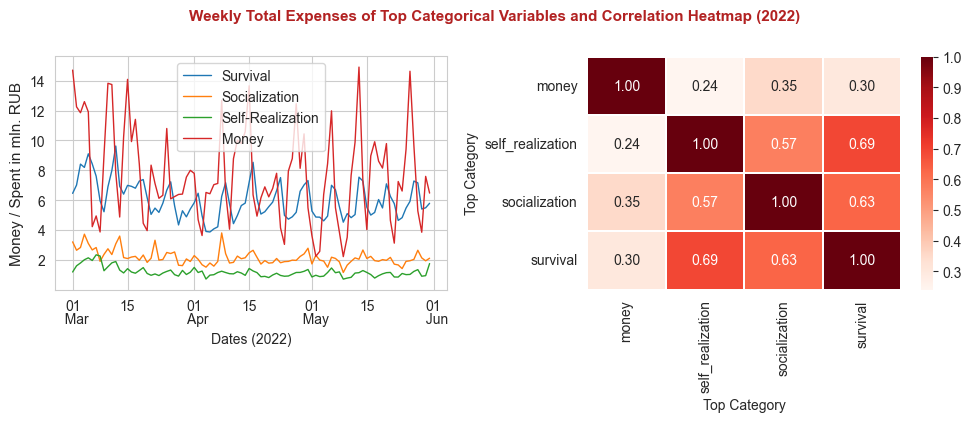

In [14]:

''' 
creating a pivot table using pandas pivot_table function is a process of grouping, summarising, aggregating,
and calculating statistics about the specified data in a DataFrame

filtering based on week, as a result, acquire the subset of data, the filtered DataFrame

'''

wdf_weekly_zoomed2022_pivoted = pd.pivot_table( working_df.loc[(working_df['DateTime'] >= '2022-03-01') & (working_df['DateTime'] <= '2022-05-31')], 
                                    values='Amount',           
                                    index=pd.Grouper(freq='D', key='DateTime'), 
                                    columns='Top Category', 
                                    aggfunc={'Amount': 'sum'},  
                                    fill_value=0, 
                                    margins=False, 
                                    dropna=True, 
                                    margins_name='All', 
                                    observed=False, 
                                    sort=True
                                    )

data = wdf_weekly_zoomed2022_pivoted 
data = data.reset_index()


fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4.2))
ax = ax.flat
for i in range(0, 2, 1):
    if i == 0:
        sns.lineplot(data=data, y=data['survival'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax = ax[i], label='Survival')
        sns.lineplot(data=data, y=data['socialization'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax=ax[i], label='Socialization')
        sns.lineplot(data=data, y=data['self_realization'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax=ax[i], label='Self-Realization')
        sns.lineplot(data=data, y=data['money'].astype(float)/1e6, x=data['DateTime'], palette="nipy_spectral", linewidth=1, ax=ax[i], label='Money')

        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days:
        sec = ax[i].secondary_xaxis(location = -0.075) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        sec.set_xlabel('Dates (2022)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis

        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('Money / Spent in mln. RUB', fontsize=11)
    else:
        sns.heatmap(round(data.corr(), 2), annot=True, ax=ax[i], cmap="Reds", fmt='.2f', linewidths=.03)
        fig.subplots_adjust(top=0.90)   

fig.suptitle('Weekly Total Expenses of Top Categorical Variables and Correlation Heatmap (2022)', fontsize = 11, fontweight = 'bold', color = 'firebrick', y = 0.995)
#plt.savefig('Weekly_Total_Expenses_of_Top_Categorical_Variables_and_Correlation_Heatmap_2022.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

## **3. Calculating between March 2019 - March 2020 and March 2021 - March 2022** 

## 3.1 Calculating the amount difference between March 2019 and March 2020

In [15]:
wdf_032019_pivoted = take_desired_interval(working_df, '2019-03-15', '2019-03-31')

wdf_032020_pivoted = take_desired_interval(working_df, '2020-03-15', '2020-03-31')

wdf_032020_032019 = wdf_032020_pivoted.sub(wdf_032019_pivoted, axis='columns', level = None, fill_value = 0) 

wdf_032020_032019

Top Category,money,self_realization,socialization,survival
Client,,,,
224,0.0000,0.0000,-0.3669,0.3669
1108,-0.2815,-0.0803,0.0000,0.3618
1117,-0.2568,-0.1458,-0.1180,0.5207
1197,0.7031,0.0000,0.0000,-0.7031
1223,0.1555,0.0000,-0.0310,-0.1245
...,...,...,...,...
3560436,0.6446,0.2149,0.0376,0.1029
3561841,0.4255,0.0980,0.0543,-0.5779
3561945,0.0000,0.0000,-0.1501,0.1501


## 3.2 Calculating the amount difference between March 2022 and March 2021

In [16]:
wdf_032021_pivoted = take_desired_interval(working_df, '2021-03-15', '2021-03-31')

wdf_032022_pivoted = take_desired_interval(working_df, '2022-03-15', '2022-03-31')

wdf_032022_032021 = wdf_032022_pivoted.sub(wdf_032021_pivoted, axis='columns', level = None, fill_value = 0) 

wdf_032022_032021

Top Category,money,self_realization,socialization,survival
Client,,,,
224,0.0000,0.0000,0.1498,-0.1498
1108,-0.6039,0.1850,0.0000,0.4189
1117,-0.1964,-0.1015,-0.1100,-0.5921
1197,0.0000,-0.7738,-0.0447,0.8185
1223,0.0000,0.0000,0.0000,0.0000
...,...,...,...,...
3560436,-0.8187,0.7677,0.0000,0.0509
3561841,0.1315,-0.1917,-0.1897,0.2499
3561945,-0.9318,0.0000,0.0000,0.9318


In [17]:
''' finding unique clients in both dataframes '''

unique_clients = wdf_032020_032019.index.intersection(wdf_032022_032021.index)

wdf_032020_032019 = wdf_032020_032019[wdf_032020_032019.index.isin(unique_clients)]

wdf_032022_032021 = wdf_032022_032021[wdf_032022_032021.index.isin(unique_clients)]

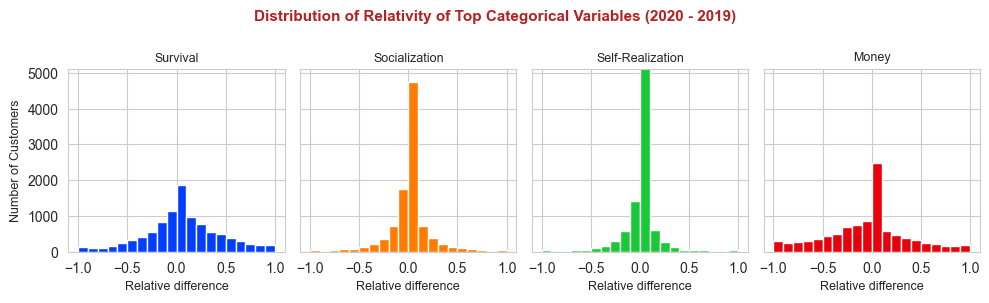

In [18]:

''' plotting the graph '''
colors = sns.color_palette(palette = 'bright', n_colors = 4,)

fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, tight_layout=True, figsize=(10, 3))

plt.subplot(141)
plt.hist(wdf_032020_032019['survival'], bins=20, color = colors[0])
plt.ylim(0, 5100)
plt.ylabel('Number of Customers', fontsize = 9)
plt.xlabel('Relative difference', fontsize = 9)
plt.title('Survival', fontsize = 9)

plt.subplot(142)
plt.hist(wdf_032020_032019['socialization'], bins=20, color = colors[1])
plt.ylim(0, 5100)
plt.xlabel('Relative difference', fontsize = 9)
plt.title('Socialization', fontsize = 9)

plt.subplot(143)
plt.hist(wdf_032020_032019['self_realization'], bins=20, color = colors[2])
plt.ylim(0, 5100)
plt.xlabel('Relative difference', fontsize = 9)
plt.title('Self-Realization', fontsize = 9)

plt.subplot(144)
plt.hist(wdf_032020_032019['money'], bins=20, color = colors[3])
plt.ylim(0, 5100)
plt.xlabel('Relative difference', fontsize = 9)
plt.title('Money', fontsize = 9)

fig.suptitle("Distribution of Relativity of Top Categorical Variables (2020 - 2019)", fontsize = 11, fontweight = 'bold', color = 'firebrick', y = 0.995)
#plt.savefig('Distribution_ofTop_Categorical_Variables_2020_2019.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

## 3.2 Segmentation process

In [19]:

model_KMeans = KMeans(n_clusters = 4, init = 'k-means++', n_init = 100, max_iter = 300, tol = 0.0001, random_state = 40, copy_x = True, algorithm = 'elkan')

''' fitting the model to our dataset '''    
model_KMeans.fit(wdf_032020_032019[['survival', 'socialization', 'self_realization', 'money']])
''' predicting after fitting has been done'''  
predicted_values = model_KMeans.predict(wdf_032020_032019[['survival', 'socialization', 'self_realization', 'money']])

''' assigning new column to the wdf_032020_032019 dataframe and inserting the predicted values'''  
wdf_032020_032019['clusters_2020_2019'] = predicted_values


wdf_032020_032019

Top Category,money,self_realization,socialization,survival,clusters_2020_2019
Client,,,,,
224,0.0000,0.0000,-0.3669,0.3669,3
1108,-0.2815,-0.0803,0.0000,0.3618,3
1117,-0.2568,-0.1458,-0.1180,0.5207,3
1197,0.7031,0.0000,0.0000,-0.7031,2
1223,0.1555,0.0000,-0.0310,-0.1245,0
...,...,...,...,...,...
3560436,0.6446,0.2149,0.0376,0.1029,2
3561841,0.4255,0.0980,0.0543,-0.5779,2
3561945,0.0000,0.0000,-0.1501,0.1501,3


In [20]:

''' pd.DataFrame creates index by default '''

temp_2020_2019 = pd.DataFrame(wdf_032020_032019['clusters_2020_2019'].value_counts())

''' removing index from the temp_2020_2019 dataframe and renaming the colunms then sorting the dataframe '''

temp_2020_2019 = temp_2020_2019.reset_index() 

temp_2020_2019.rename(columns = {'index':'clusters_2020_2019', 'clusters_2020_2019':'number of clients in each cluster'}, inplace = True)

temp_2020_2019 = temp_2020_2019.sort_values(by = 'clusters_2020_2019', ascending = True)

temp_2020_2019


,clusters_2020_2019,number of clients in each cluster
0,0,4179
2,1,1780
3,2,1747
1,3,2235


## 3.3 Visualization process



The scatter plot shows how t-SNE has mapped the dataset into a 2D space (2020 - 2019):


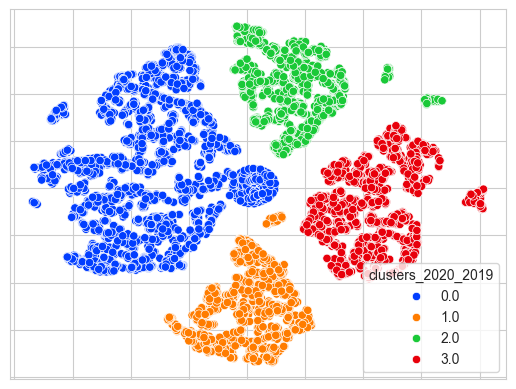

In [21]:

print(f'\n')
print('The scatter plot shows how t-SNE has mapped the dataset into a 2D space (2020 - 2019):')

model_TSNE = TSNE(n_components = 2, random_state = 0)

tsne_data = model_TSNE.fit_transform(wdf_032020_032019)

tsne_data = np.vstack((tsne_data.T, wdf_032020_032019['clusters_2020_2019'])).T

tsne_df = pd.DataFrame(data = tsne_data, columns =("Dimension_1", "Dimension_2", "clusters_2020_2019"))

g = sns.scatterplot(data=tsne_df, x='Dimension_1', y='Dimension_2', hue='clusters_2020_2019', palette="bright")
g.set(yticklabels=[])
g.set(ylabel=None)
g.set(xticklabels=[])
g.set(xlabel=None)

plt.show()


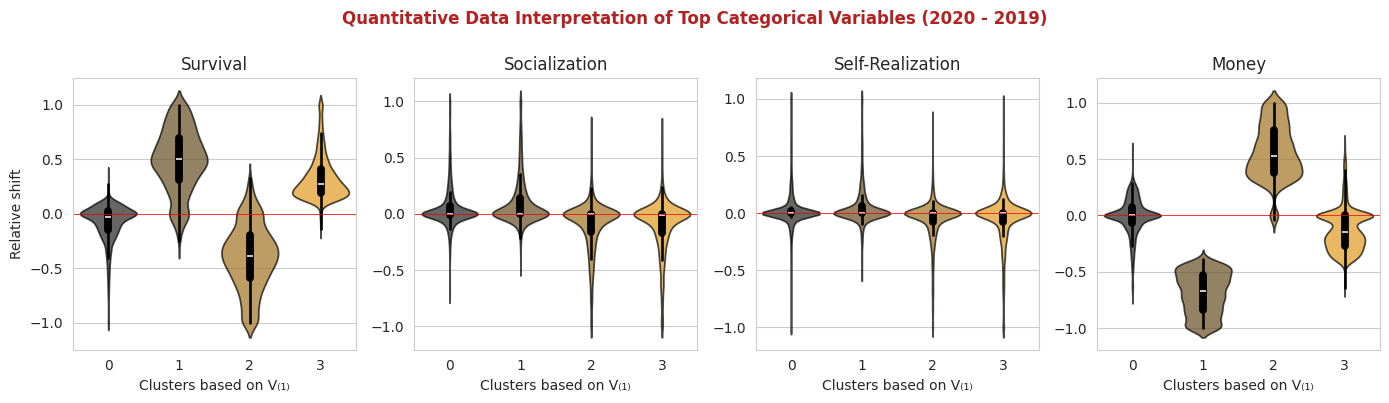

In [22]:
''' 
Violin Plot is a method to visualize the distribution of numerical data of different variables

V1 stands for the first variance which imples the difference between 2020-2019 calculation, that is, V1: 2020 - 2019 

'''

''' setting global font properties, ensure the font supports subscripts and superscripts of the Unicode characters '''

rcParams['font.family'] = 'DejaVu Sans'  

topcategories=['survival', 'socialization', 'self_realization', 'money']

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (14, 4)) 
ax = ax.flat
for i, j in enumerate(topcategories): 
        
        sns.violinplot(data = wdf_032020_032019, x = 'clusters_2020_2019', y = wdf_032020_032019[j], hue = 'clusters_2020_2019', ax = ax[i], color = 'orange', alpha = 0.7, linecolor='black')
        plt.grid(axis='y')
        ax[i].axhline(0., lw=0.5, c='red')
        ax[i].set_xlabel('Clusters based on V\u208D\u2081\u208E')
        ax[i].get_legend().set_visible(False)
        if i == 0:
            ax[i].set_ylabel('Relative shift')
            ax[i].set_title('Survival')
        if i == 1:
               ax[i].set_title('Socialization')
               ax[i].set_ylabel('')  
               #ax[i].set_ylim(-4, 2.5)               
        if i == 2:
               ax[i].set_title('Self-Realization')
               ax[i].set_ylabel('')
               #ax[i].set_ylim(-2.8, 2.5) 
        if i == 3:
               ax[i].set_title('Money')
               ax[i].set_ylabel('')    


fig.suptitle("Quantitative Data Interpretation of Top Categorical Variables (2020 - 2019)", fontsize = 12, fontweight = 'bold', color = 'firebrick', y = 0.995)
#plt.savefig('Quantitative_Data_Interpretation_ofTop_Categorical_Variables_2020_2019.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

## **4. Calculating between March 2021 and March 2022**


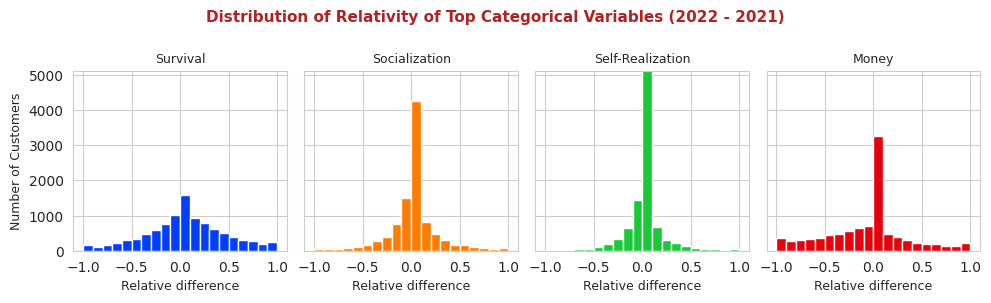

In [23]:
''' plotting the graph '''
colors = sns.color_palette(palette = 'bright', n_colors = 4,)

fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, tight_layout=True, figsize=(10, 3))

plt.subplot(141)
plt.hist(wdf_032022_032021['survival'], bins=20, color = colors[0])
plt.ylim(0, 5100)
plt.ylabel('Number of Customers', fontsize = 9)
plt.xlabel('Relative difference', fontsize = 9)
plt.title('Survival', fontsize = 9)

plt.subplot(142)
plt.hist(wdf_032022_032021['socialization'], bins=20, color = colors[1])
plt.ylim(0, 5100)
plt.xlabel('Relative difference', fontsize = 9)
plt.title('Socialization', fontsize = 9)

plt.subplot(143)
plt.hist(wdf_032022_032021['self_realization'], bins=20, color = colors[2])
plt.ylim(0, 5100)
plt.xlabel('Relative difference', fontsize = 9)
plt.title('Self-Realization', fontsize = 9)

plt.subplot(144)
plt.hist(wdf_032022_032021['money'], bins=20, color = colors[3])
plt.ylim(0, 5100)
plt.xlabel('Relative difference', fontsize = 9)
plt.title('Money', fontsize = 9)

fig.suptitle("Distribution of Relativity of Top Categorical Variables (2022 - 2021)", fontsize = 11, fontweight = 'bold', color = 'firebrick', y = 0.995)
#plt.savefig('Distribution_ofTop_Categorical_Variables_2022_2021.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

## 5.2 Segmentation process



In [24]:
''' predicting after fitting has been done'''  
predicted_values = model_KMeans.predict(wdf_032022_032021[['survival', 'socialization', 'self_realization', 'money']])

''' assigning new column to the wdf_032022_032021 dataframe and inserting the predicted values''' 
wdf_032022_032021['clusters_2022_2021'] = predicted_values


wdf_032022_032021

Top Category,money,self_realization,socialization,survival,clusters_2022_2021
Client,,,,,
224,0.0000,0.0000,0.1498,-0.1498,0
1108,-0.6039,0.1850,0.0000,0.4189,1
1117,-0.1964,-0.1015,-0.1100,-0.5921,0
1197,0.0000,-0.7738,-0.0447,0.8185,3
1223,0.0000,0.0000,0.0000,0.0000,0
...,...,...,...,...,...
3560436,-0.8187,0.7677,0.0000,0.0509,1
3561841,0.1315,-0.1917,-0.1897,0.2499,3
3561945,-0.9318,0.0000,0.0000,0.9318,1


In [25]:
''' pd.DataFrame creates index by default '''

temp_2022_2021 = pd.DataFrame(wdf_032022_032021['clusters_2022_2021'].value_counts())

''' removing index from the temp_2022_2021 dataframe and renaming the colunms then sorting the dataframe '''

temp_2022_2021 = temp_2022_2021.reset_index() 

temp_2022_2021.rename(columns = {'index':'clusters_2022_2021', 'clusters_2022_2021':'number of clients in each cluster'}, inplace = True)

temp_2022_2021 = temp_2022_2021.sort_values(by = 'clusters_2022_2021', ascending = True)

temp_2022_2021

,clusters_2022_2021,number of clients in each cluster
0,0,4193
2,1,1889
3,2,1518
1,3,2341


## 5.3 Visualization process



The scatter plot shows how t-SNE has mapped the dataset into a 2D space (2022 - 2021):


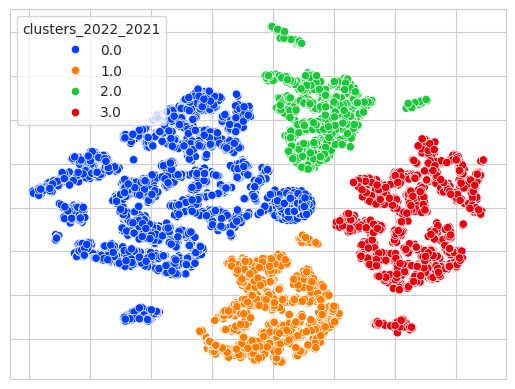

In [26]:
print(f'\n')
print('The scatter plot shows how t-SNE has mapped the dataset into a 2D space (2022 - 2021):')

model_TSNE = TSNE(n_components = 2, random_state = 0)

tsne_data = model_TSNE.fit_transform(wdf_032022_032021)

tsne_data = np.vstack((tsne_data.T, wdf_032022_032021['clusters_2022_2021'])).T

tsne_df = pd.DataFrame(data = tsne_data, columns =("Dimension_1", "Dimension_2", "clusters_2022_2021"))

g = sns.scatterplot(data=tsne_df, x='Dimension_1', y='Dimension_2', hue='clusters_2022_2021', palette="bright")
g.set(yticklabels=[])
g.set(ylabel=None)
g.set(xticklabels=[])
g.set(xlabel=None)

plt.show()


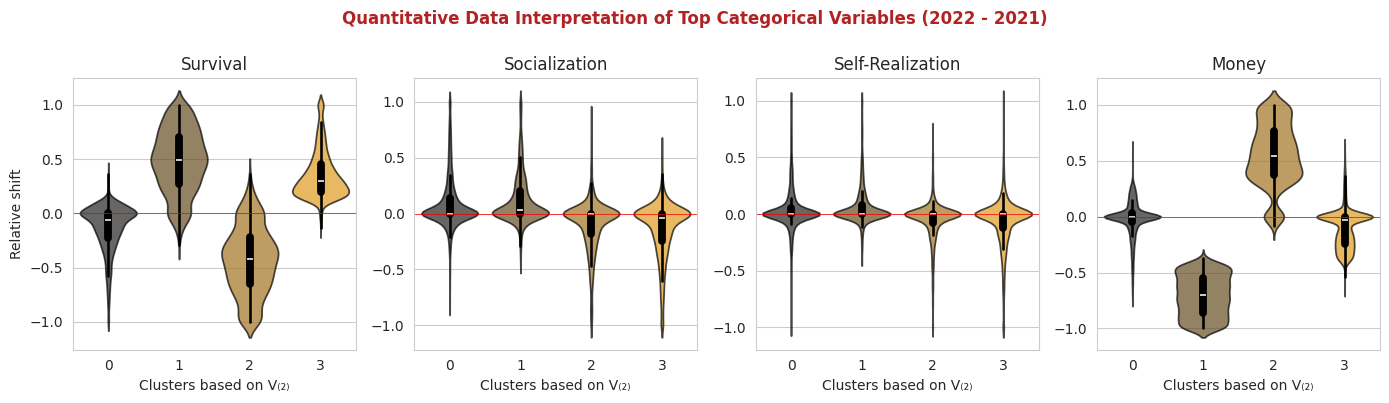

In [27]:
''' 
Violin Plot is a method to visualize the distribution of numerical data of different variables

V3 stands for the second variance which imples the difference between 2022-2021 calculation, that is, V3: 2022 - 2021 

'''

''' setting global font properties, ensure the font supports subscripts and superscripts of the Unicode characters '''

rcParams['font.family'] = 'DejaVu Sans'  


topcategories=['survival', 'socialization', 'self_realization', 'money']

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (14, 4)) 
ax = ax.flat
for i, j in enumerate(topcategories): 
        
        sns.violinplot(data = wdf_032022_032021, x = 'clusters_2022_2021', y = wdf_032022_032021[j], hue = 'clusters_2022_2021', ax = ax[i], color = 'orange', alpha = 0.7, linecolor='black')
        plt.grid(axis='y')
        ax[i].axhline(0., lw=0.5, c='red')
        ax[i].set_xlabel('Clusters based on V\u208D\u2082\u208E')
        ax[i].get_legend().set_visible(False)
        if i == 0:
            ax[i].set_ylabel('Relative shift')
            ax[i].set_title('Survival')
        if i == 1:
               ax[i].set_title('Socialization')
               ax[i].set_ylabel('')  
               #ax[i].set_ylim(-2.5, 2.5) 
        if i == 2:
               ax[i].set_title('Self-Realization')
               ax[i].set_ylabel('')
               #ax[i].set_ylim(-2.5, 2.5) 
        if i == 3:
               ax[i].set_title('Money')
               ax[i].set_ylabel('')    


fig.suptitle("Quantitative Data Interpretation of Top Categorical Variables (2022 - 2021)", fontsize = 12, fontweight = 'bold', color = 'firebrick', y = 0.995)
#plt.savefig('Quantitative_Data_Interpretation_ofTop_Categorical_Variables_2022_2021.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

## **5.4 Assessment of the strategical behavior in 2022-2021 according to 2020-2019**  

In [28]:
''' 

merging/combining DataFrames based on the 'client' column

inner: use intersection of keys from both DataFrames, in our case key is 'Client' index
on: column or index level names to join on, these must be found in both DataFrames
returns: a DataFrame of the two merged objects

'''

wdf_merged_m1 = wdf_032022_032021.merge(wdf_032020_032019['clusters_2020_2019'], on='Client', how='inner')

wdf_merged_m1

,money,self_realization,socialization,survival,clusters_2022_2021,clusters_2020_2019
Client,,,,,,
224,0.0000,0.0000,0.1498,-0.1498,0,3
1108,-0.6039,0.1850,0.0000,0.4189,1,3
1117,-0.1964,-0.1015,-0.1100,-0.5921,0,3
1197,0.0000,-0.7738,-0.0447,0.8185,3,2
1223,0.0000,0.0000,0.0000,0.0000,0,0
...,...,...,...,...,...,...
3560436,-0.8187,0.7677,0.0000,0.0509,1,2
3561841,0.1315,-0.1917,-0.1897,0.2499,3,2
3561945,-0.9318,0.0000,0.0000,0.9318,1,3


In [29]:
'''
selecting clients who stayed unchanged/identical/same in their clusters, who did not change thier clusters

'''

wdf_kept_clients = wdf_merged_m1[wdf_merged_m1['clusters_2022_2021'] == wdf_merged_m1['clusters_2020_2019']]

wdf_kept_clients

,money,self_realization,socialization,survival,clusters_2022_2021,clusters_2020_2019
Client,,,,,,
1223,0.0000,0.0000,0.0000,0.0000,0,0
2213,0.0805,-0.0704,0.0283,-0.0385,0,0
5044,-0.2158,-0.0856,0.1269,0.1745,3,3
5737,0.0000,-0.1906,-0.1006,0.2911,3,3
7689,0.0000,0.0000,-0.3557,0.3557,3,3
...,...,...,...,...,...,...
3543340,-0.3159,0.3756,0.0000,-0.0597,0,0
3544746,0.0000,-0.3098,0.2823,0.0275,0,0
3545900,-0.3679,0.0000,0.3305,0.0374,0,0


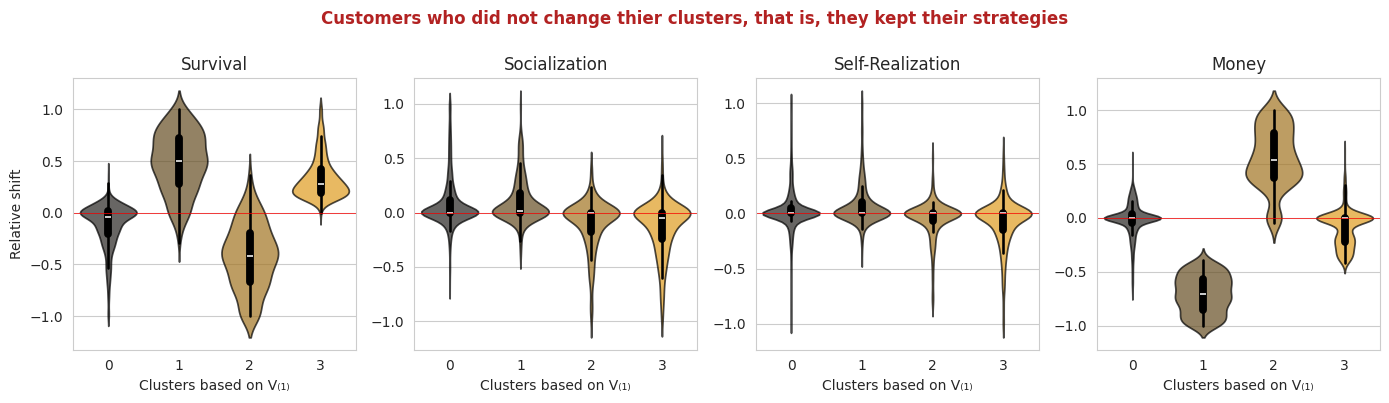

In [30]:
''' 
Violin Plot is a method to visualize the distribution of numerical data of different variables

V1 stands for the first variance which imples the difference between 2020-2019 calculation, that is, V1: 2020 - 2019

'''

topcategories=['survival', 'socialization', 'self_realization', 'money']

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (14, 4)) 
ax = ax.flat
for i,j in enumerate(topcategories):

       sns.violinplot(data = wdf_kept_clients, x = 'clusters_2020_2019', y = wdf_kept_clients.loc[:,j], hue = 'clusters_2020_2019', ax = ax[i], color = 'orange', alpha = 0.7, linecolor='black')
          
       plt.grid(axis='y')        
       ax[i].axhline(0., lw=0.5, c='red')
       ax[i].set_xlabel('Clusters based on V\u208D\u2081\u208E')
       ax[i].get_legend().set_visible(False)
       if i == 0:
           ax[i].set_ylabel('Relative shift')
           ax[i].set_title('Survival')
       if i == 1:
              ax[i].set_title('Socialization')
              ax[i].set_ylabel('')  
       if i == 2:
              ax[i].set_title('Self-Realization')
              ax[i].set_ylabel('')
       if i == 3:
              ax[i].set_title('Money')
              ax[i].set_ylabel('')    

fig.suptitle("Customers who did not change thier clusters, that is, they kept their strategies", fontsize = 12, fontweight = 'bold', color = 'firebrick', y = 0.995)
#plt.savefig('Customers_who_did_not_change_thier_clusters.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

In [31]:
'''
selecting clients who changed thier clusters

'''

wdf_changed_clients = wdf_merged_m1[wdf_merged_m1['clusters_2022_2021'] != wdf_merged_m1['clusters_2020_2019']]

wdf_changed_clients

,money,self_realization,socialization,survival,clusters_2022_2021,clusters_2020_2019
Client,,,,,,
224,0.0000,0.0000,0.1498,-0.1498,0,3
1108,-0.6039,0.1850,0.0000,0.4189,1,3
1117,-0.1964,-0.1015,-0.1100,-0.5921,0,3
1197,0.0000,-0.7738,-0.0447,0.8185,3,2
1555,0.0000,0.0000,-0.0752,0.0752,0,2
...,...,...,...,...,...,...
3560436,-0.8187,0.7677,0.0000,0.0509,1,2
3561841,0.1315,-0.1917,-0.1897,0.2499,3,2
3561945,-0.9318,0.0000,0.0000,0.9318,1,3


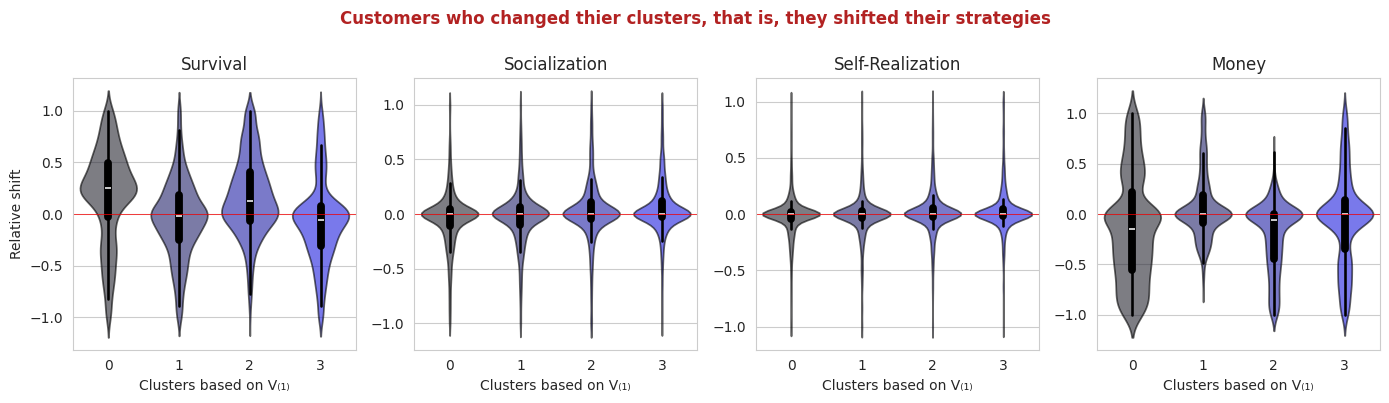

In [32]:
''' 
Violin Plot is a method to visualize the distribution of numerical data of different variables

V1 stands for the first variance which imples the difference between 2020-2019 calculation, that is, V1: 2020 - 2019

'''

topcategories=['survival', 'socialization', 'self_realization', 'money']

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (14, 4)) 
ax = ax.flat
for i,j in enumerate(topcategories):

       sns.violinplot(data = wdf_changed_clients, x = 'clusters_2020_2019', y = wdf_changed_clients.loc[:,j], hue = 'clusters_2020_2019', ax = ax[i], color = 'blue', alpha = 0.6, linecolor='black')
          
       plt.grid(axis='y')        
       ax[i].axhline(0., lw=0.5, c='red')
       ax[i].set_xlabel('Clusters based on V\u208D\u2081\u208E')
       ax[i].get_legend().set_visible(False)
       if i == 0:
           ax[i].set_ylabel('Relative shift')
           ax[i].set_title('Survival')
       if i == 1:
              ax[i].set_title('Socialization')
              ax[i].set_ylabel('')  
       if i == 2:
              ax[i].set_title('Self-Realization')
              ax[i].set_ylabel('')
       if i == 3:
              ax[i].set_title('Money')
              ax[i].set_ylabel('')    


fig.suptitle("Customers who changed thier clusters, that is, they shifted their strategies", fontsize = 12, fontweight = 'bold', color = 'firebrick', y = 0.995)
#plt.savefig('Customers_who_change_thier_clusters.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

## 5.5 Combining two latest violin plots, first who moved their strategies then who kept their strategies/clusters

In [33]:
print('V\u208D\u2081\u208E')

V₍₁₎


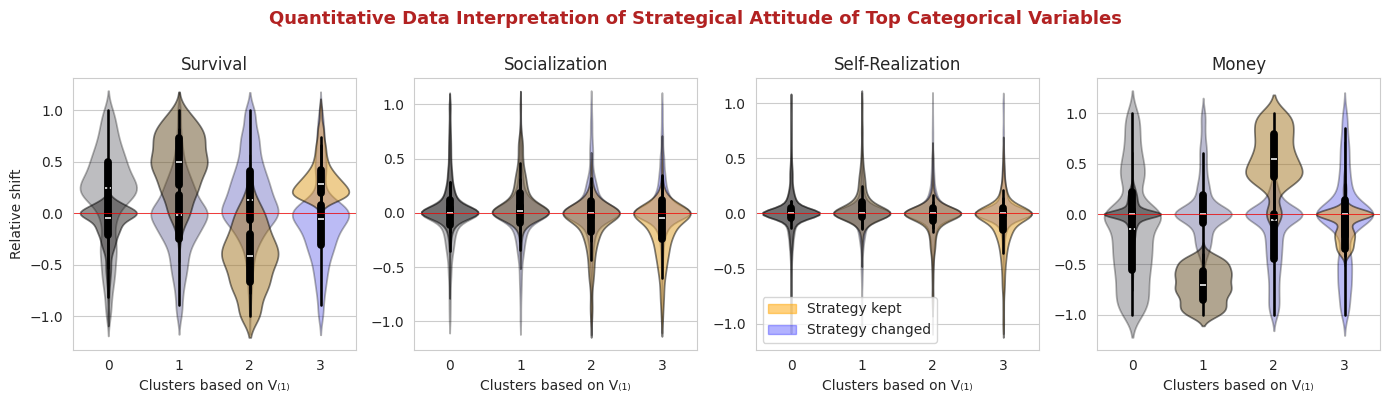

In [34]:
''' 
Violin Plot is a method to visualize the distribution of numerical data of different variables

V1 stands for the first variance which imples the difference between 2020-2019 calculation, that is, V1: 2020 - 2019

'''

''' setting global font properties, ensure the font supports subscripts and superscripts of the Unicode characters '''


rcParams['font.family'] = 'DejaVu Sans'  

topcategories=['survival', 'socialization', 'self_realization', 'money']

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (14, 4)) 
ax = ax.flat
for i,j in enumerate(topcategories):
       
       sns.violinplot(data = wdf_changed_clients, x = 'clusters_2020_2019', y = wdf_changed_clients.loc[:,j], hue = 'clusters_2020_2019', ax = ax[i], color = 'blue', alpha = 0.3, linecolor='black')

       sns.violinplot(data = wdf_kept_clients,  x = 'clusters_2020_2019', y = wdf_kept_clients.loc[:,j], hue = 'clusters_2020_2019', ax = ax[i], color = 'orange', alpha = 0.5, linecolor='black')
    
               
       plt.grid(axis='y')        
       ax[i].axhline(0., lw=0.5, c='red')
       ax[i].set_xlabel('Clusters based on V\u208D\u2081\u208E') 
       ax[i].get_legend().set_visible(False)
       if i == 0:
           ax[i].set_ylabel('Relative shift')
           ax[i].set_title('Survival')
       if i == 1:
              ax[i].set_title('Socialization')
              ax[i].set_ylabel('')  
       if i == 2:
              ax[i].set_title('Self-Realization')
              ax[i].set_ylabel('')
              orange_patch = mpatches.Patch(color='orange', alpha = 0.5, label = 'Strategy kept')
              blue_patch = mpatches.Patch(color='blue', alpha = 0.3, label = 'Strategy changed')
              ax[i].legend(handles=[orange_patch, blue_patch], loc = 3)
       if i == 3:
              ax[i].set_title('Money')
              ax[i].set_ylabel('')    


fig.suptitle("Quantitative Data Interpretation of Strategical Attitude of Top Categorical Variables", fontsize = 13, fontweight = 'bold', color = 'firebrick', y = 0.995)
#plt.savefig('Quantitative_Data_Interpretation_ofTop_Categorical_Variables_2021_2020_and_2020_2019.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

## **6. Migration between clusters according to 2021-2020 and 2020-2019 variances**



In [35]:
wdf_merged_m1

,money,self_realization,socialization,survival,clusters_2022_2021,clusters_2020_2019
Client,,,,,,
224,0.0000,0.0000,0.1498,-0.1498,0,3
1108,-0.6039,0.1850,0.0000,0.4189,1,3
1117,-0.1964,-0.1015,-0.1100,-0.5921,0,3
1197,0.0000,-0.7738,-0.0447,0.8185,3,2
1223,0.0000,0.0000,0.0000,0.0000,0,0
...,...,...,...,...,...,...
3560436,-0.8187,0.7677,0.0000,0.0509,1,2
3561841,0.1315,-0.1917,-0.1897,0.2499,3,2
3561945,-0.9318,0.0000,0.0000,0.9318,1,3


In [36]:
list_of_migrated = []
for i in range(0, 4, 1):
    for j in range(0, 4, 1):
        var = len(wdf_merged_m1.loc[(wdf_merged_m1['clusters_2020_2019'] == i) & (wdf_merged_m1['clusters_2022_2021'] == j)].index)
        list_of_migrated.append(var)

wdf_migrated = pd.DataFrame(data = {  'from_cluster': [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3],
                                      'to_cluster':   [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3],
                                      'number_of_migrated_clients': list_of_migrated
                                   })

wdf_migrated

,from_cluster,to_cluster,number_of_migrated_clients
0,0,0,1816
1,0,1,796
2,0,2,619
3,0,3,948
4,1,0,723
5,1,1,355
6,1,2,280
7,1,3,422
8,2,0,685
9,2,1,370


In [37]:
nodes = dict(
                label = ['Cluster 0 ' + '('f'{temp_2020_2019.loc[temp_2020_2019["clusters_2020_2019"] == 0]["number of clients in each cluster"].item()}' + ')', 
                         'Cluster 1 ' + '('f'{temp_2020_2019.loc[temp_2020_2019["clusters_2020_2019"] == 1]["number of clients in each cluster"].item()}' + ')',  
                         'Cluster 2 ' + '('f'{temp_2020_2019.loc[temp_2020_2019["clusters_2020_2019"] == 2]["number of clients in each cluster"].item()}' + ')',  
                         'Cluster 3 ' + '('f'{temp_2020_2019.loc[temp_2020_2019["clusters_2020_2019"] == 3]["number of clients in each cluster"].item()}' + ')', 
                         
                         'Cluster 0 ' + '('f'{temp_2022_2021.loc[temp_2022_2021["clusters_2022_2021"] == 0]["number of clients in each cluster"].item()}' + ')', 
                         'Cluster 1 ' + '('f'{temp_2022_2021.loc[temp_2022_2021["clusters_2022_2021"] == 1]["number of clients in each cluster"].item()}' + ')',  
                         'Cluster 2 ' + '('f'{temp_2022_2021.loc[temp_2022_2021["clusters_2022_2021"] == 2]["number of clients in each cluster"].item()}' + ')', 
                         'Cluster 3 ' + '('f'{temp_2022_2021.loc[temp_2022_2021["clusters_2022_2021"] == 3]["number of clients in each cluster"].item()}' + ')'
                        ],
                color = ['blue',              'orange',           'green',              'red',             'blue',            'orange',             'green',              'red'],
                x =     [ 0.001,               0.001,              0.001,                0.001,             0.999,             0.999,                0.999,                0.999],
                y =     [ 0.001,               100/285,            200/285,              300/285,           0.001,             100/285,              200/285,              300/285],
            )

links = dict(   
               source = [  0, 0, 0, 0,  1, 1, 1, 1,  2, 2, 2, 2,  3, 3, 3, 3],    # The origin or the source nodes of the link
               target = [  4, 5, 6, 7,  4, 5, 6, 7,  4, 5, 6, 7,  4, 5, 6, 7],    # The destination or the target nodes of the link
               value =  [ wdf_migrated.iloc[0,2],
                          wdf_migrated.iloc[1,2], 
                          wdf_migrated.iloc[2,2], 
                          wdf_migrated.iloc[3,2],
                          
                          wdf_migrated.iloc[4,2],
                          wdf_migrated.iloc[5,2],
                          wdf_migrated.iloc[6,2],
                          wdf_migrated.iloc[7,2],

                          wdf_migrated.iloc[8,2],
                          wdf_migrated.iloc[9,2],
                          wdf_migrated.iloc[10,2],
                          wdf_migrated.iloc[11,2],

                          wdf_migrated.iloc[12,2],
                          wdf_migrated.iloc[13,2],
                          wdf_migrated.iloc[14,2],
                          wdf_migrated.iloc[15,2]            
                        ],                               # The width (quantity) of the links
                arrowlen = 25,
                # Color of the links
                # Target Node:   Cluster 0,      Cluster 1,     Cluster 2,      Cluster 3
                color =     [   'lightskyblue', 'lightskyblue', 'lightskyblue', 'lightskyblue',     
                                'bisque',       'bisque',       'bisque',       'bisque',    
                                'lightgreen',   'lightgreen',   'lightgreen',   'lightgreen',
                                'tomato',       'tomato',       'tomato',       'tomato'
                            ],
            )        


data = go.Sankey(node = nodes, link = links, arrangement='snap', orientation = 'h') #  orientation = 'v',
fig = go.Figure(data)
fig.update_layout(title = '------>' + '                             Flow of Customers between Clusters: from clusters V\u208D\u2081\u208E to clusters V\u208D\u2082\u208E', font_size=12)
#plt.savefig('Migration_from_Clusters_to_Clusters.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.show()

## **7. Splitting the expenditures according to the obtained clusters by years**


## 7.1 By 2020

In [38]:
wdf_temp = working_df.merge(wdf_032020_032019['clusters_2020_2019'], on='Client', how='inner')
topcategories = ['survival', 'socialization', 'self_realization', 'money']

for i, j in enumerate(topcategories):
    
    temp = wdf_temp[(wdf_temp['Top Category'] == j) & ((wdf_temp['DateTime'] >= '2020-03-15') & (wdf_temp['DateTime'] <= '2020-03-31'))].groupby(by = ['DateTime', 'clusters_2020_2019'], 
                                                                                  axis=0, 
                                                                                  level=None,
                                                                                  as_index=True, 
                                                                                  sort=True, 
                                                                                  group_keys=True, 
                                                                                  observed=False, 
                                                                                  dropna=True)['Amount'].sum()
    if i == 0:
       survival_clusters = temp.to_frame()
       survival_clusters = survival_clusters.reset_index()

    elif i == 1:
       socialization_clusters = temp.to_frame()
       socialization_clusters = socialization_clusters.reset_index()

    elif i == 2:
       self_realization_clusters = temp.to_frame()
       self_realization_clusters = self_realization_clusters.reset_index()
    else:
       money_clusters = temp.to_frame()
       money_clusters = money_clusters.reset_index()


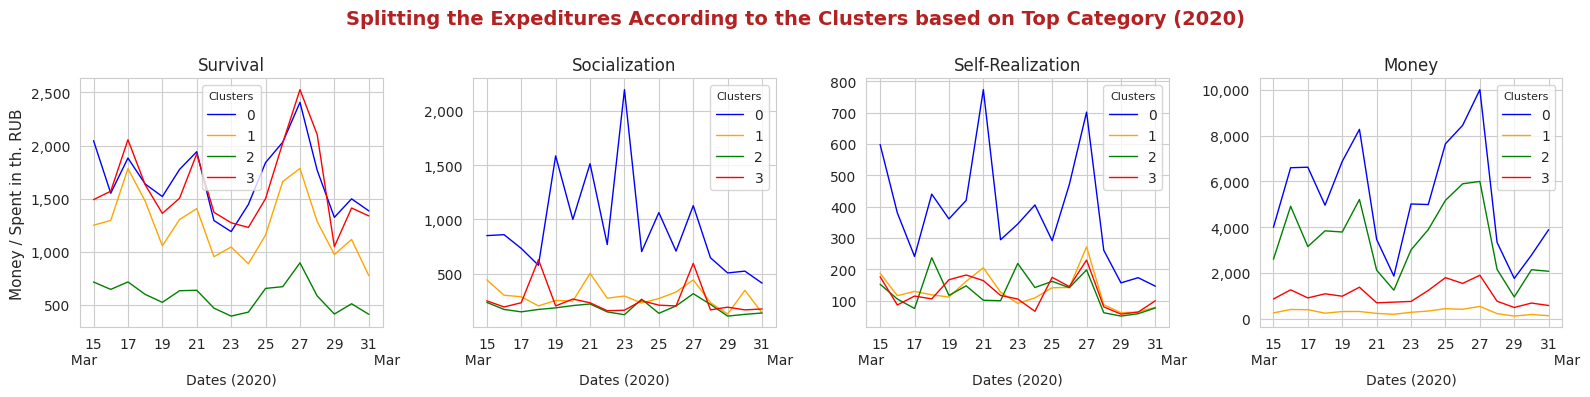

In [39]:
colors = ['blue', 'orange', 'green', 'red']
pal = sns.color_palette(colors, 4)

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (16, 4))
ax = ax.flat
for i in range(0, 4, 1):
    if i == 0:
        sns.lineplot(data=survival_clusters, y=survival_clusters['Amount'].astype(float)/1e3, x=survival_clusters['DateTime'], hue = survival_clusters['clusters_2020_2019'], palette=pal, linewidth=1, ax = ax[i])

        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        sec.set_xlabel('Dates (2020)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='Clusters', loc='best') 
        ax[i].set_title('Survival')
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('Money / Spent in th. RUB', fontsize=11) 

    elif i == 1:
        sns.lineplot(data=socialization_clusters, y=socialization_clusters['Amount'].astype(float)/1e3, x=socialization_clusters['DateTime'], hue = socialization_clusters['clusters_2020_2019'], palette=pal, linewidth=1, ax = ax[i])

        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        sec.set_xlabel('Dates (2020)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='Clusters', loc='best')
        ax[i].set_title('Socialization')
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')

    elif i == 2:
        sns.lineplot(data=self_realization_clusters, y=self_realization_clusters['Amount'].astype(float)/1e3, x=self_realization_clusters['DateTime'], hue = self_realization_clusters['clusters_2020_2019'], palette=pal, linewidth=1, ax = ax[i])


        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        sec.set_xlabel('Dates (2020)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='Clusters', loc='best')
        ax[i].set_title('Self-Realization')
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')

    
    else: 
        sns.lineplot(data=money_clusters, y=money_clusters['Amount'].astype(float)/1e3, x=money_clusters['DateTime'], hue = money_clusters['clusters_2020_2019'], palette=pal, linewidth=1, ax = ax[i])


        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        sec.set_xlabel('Dates (2020)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='Clusters', loc='best')
        ax[i].set_title('Money')
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')
        
fig.suptitle('Splitting the Expeditures According to the Clusters based on Top Category (2020)', fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
#plt.savefig('Splitting_the_expeditures_according_to_the_clusters_2020.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()


## 7.2 By 2022

In [40]:
wdf_temp = working_df.merge(wdf_032022_032021['clusters_2022_2021'], on='Client', how='inner')
topcategories = ['survival', 'socialization', 'self_realization', 'money']

for i, j in enumerate(topcategories):
    
    temp = wdf_temp[(wdf_temp['Top Category'] == j) & ((wdf_temp['DateTime'] >= '2022-03-15') & (wdf_temp['DateTime'] <= '2022-03-31'))].groupby(by = ['DateTime', 'clusters_2022_2021'], 
                                                                                  axis=0, 
                                                                                  level=None,
                                                                                  as_index=True, 
                                                                                  sort=True, 
                                                                                  group_keys=True, 
                                                                                  observed=False, 
                                                                                  dropna=True)['Amount'].sum()
    if i == 0:
       survival_clusters = temp.to_frame()
       survival_clusters = survival_clusters.reset_index()

    elif i == 1:
       socialization_clusters = temp.to_frame()
       socialization_clusters = socialization_clusters.reset_index()

    elif i == 2:
       self_realization_clusters = temp.to_frame()
       self_realization_clusters = self_realization_clusters.reset_index()
    else:
       money_clusters = temp.to_frame()
       money_clusters = money_clusters.reset_index()

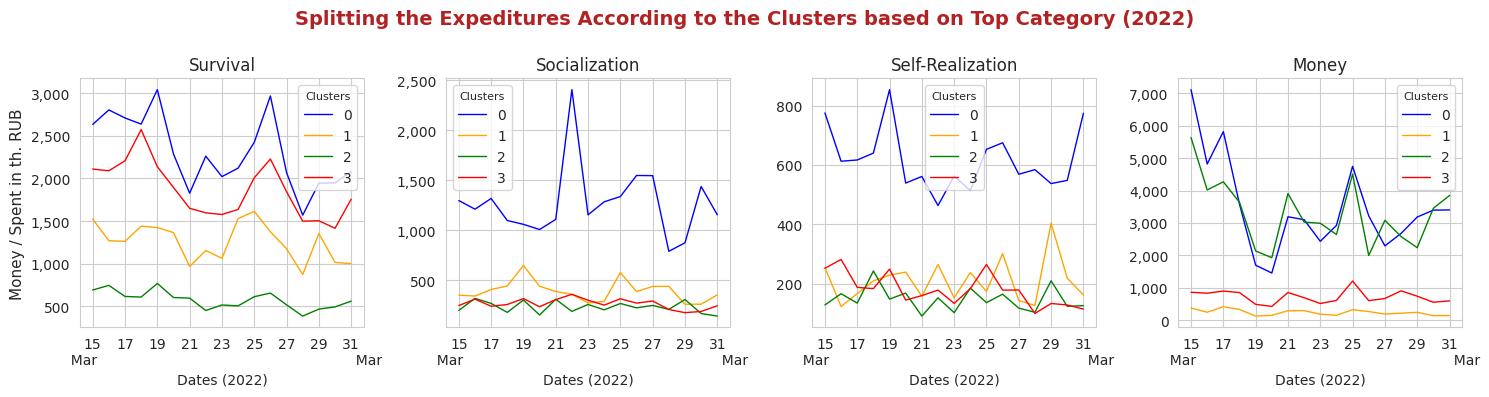

In [41]:
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (15, 4))
ax = ax.flat
for i in range(0, 4, 1):
    if i == 0:
        sns.lineplot(data=survival_clusters, y=survival_clusters['Amount'].astype(float)/1e3, x=survival_clusters['DateTime'], hue = survival_clusters['clusters_2022_2021'], palette=pal, linewidth=1, ax = ax[i])

        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days:
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        sec.set_xlabel('Dates (2022)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8')
        sns.move_legend(ax[i], title='Clusters', loc='best') 
        ax[i].set_title('Survival')
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('Money / Spent in th. RUB', fontsize=11) 

    elif i == 1:
        sns.lineplot(data=socialization_clusters, y=socialization_clusters['Amount'].astype(float)/1e3, x=socialization_clusters['DateTime'], hue = socialization_clusters['clusters_2022_2021'], palette=pal, linewidth=1, ax = ax[i])

        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days:
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        sec.set_xlabel('Dates (2022)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8')
        sns.move_legend(ax[i], title='Clusters', loc='best')
        ax[i].set_title('Socialization')
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')

    elif i == 2:
        sns.lineplot(data=self_realization_clusters, y=self_realization_clusters['Amount'].astype(float)/1e3, x=self_realization_clusters['DateTime'], hue = self_realization_clusters['clusters_2022_2021'], palette=pal, linewidth=1, ax = ax[i])


        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days:
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        sec.set_xlabel('Dates (2022)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8')
        sns.move_legend(ax[i], title='Clusters', loc='best')
        ax[i].set_title('Self-Realization')
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')

    
    else: 
        sns.lineplot(data=money_clusters, y=money_clusters['Amount'].astype(float)/1e3, x=money_clusters['DateTime'], hue = money_clusters['clusters_2022_2021'], palette=pal, linewidth=1, ax = ax[i])


        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days:
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        sec.set_xlabel('Dates (2022)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8')
        sns.move_legend(ax[i], title='Clusters', loc='best')
        ax[i].set_title('Money')
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')
        
fig.suptitle('Splitting the Expeditures According to the Clusters based on Top Category (2022)', fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
#plt.savefig('Splitting_the_expeditures_according_to_the_clusters_2022.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

## 7.3 Food, Health, Travel and Kids by 2020

In [42]:
wdf_temp = working_df.merge(wdf_032020_032019['clusters_2020_2019'], on='Client', how='inner')
topcategories = ['food', 'health', 'travel', 'kids']

for i, j in enumerate(topcategories):
    
    temp = wdf_temp[(wdf_temp['Category'] == j) & ((wdf_temp['DateTime'] >= '2020-02-01') & (wdf_temp['DateTime'] <= '2020-05-01'))].groupby(by = ['DateTime', 'clusters_2020_2019'], 
                                                                                  axis=0, 
                                                                                  level=None,
                                                                                  as_index=True, 
                                                                                  sort=True, 
                                                                                  group_keys=True, 
                                                                                  observed=False, 
                                                                                  dropna=True)['Amount'].sum()
    if i == 0:
       food_clusters = temp.to_frame()
       food_clusters = food_clusters.reset_index()

    elif i == 1:
       health_clusters = temp.to_frame()
       health_clusters = health_clusters.reset_index()

    elif i == 2:
       travel_clusters = temp.to_frame()
       travel_clusters = travel_clusters.reset_index()
    else:
       kids_clusters = temp.to_frame()
       kids_clusters = kids_clusters.reset_index()

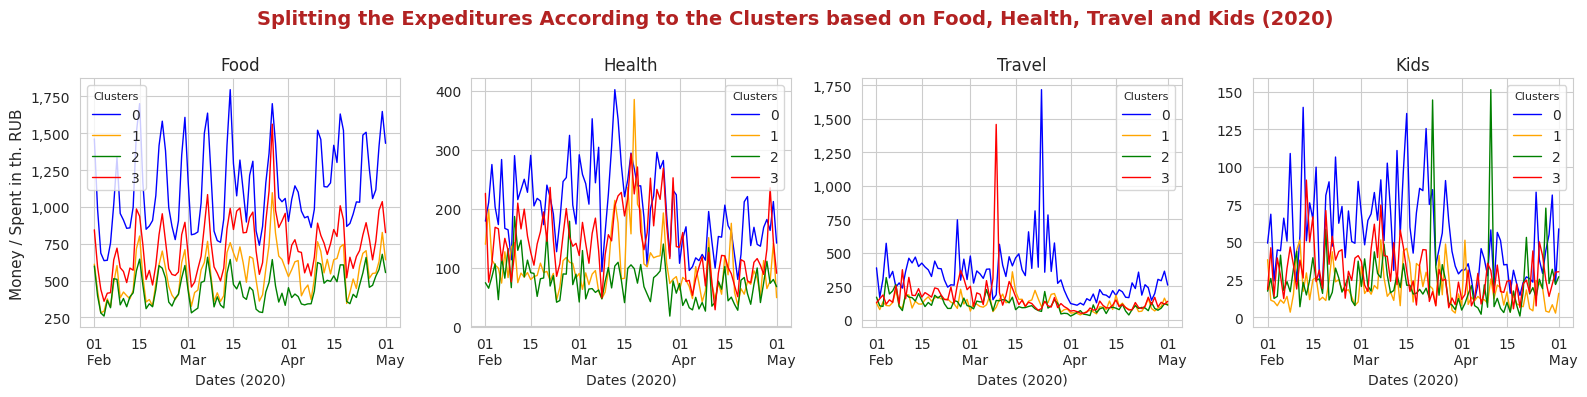

In [43]:
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (16, 4))
ax = ax.flat
for i in range(0, 4, 1):
    if i == 0:
        sns.lineplot(data=food_clusters, y=food_clusters['Amount'].astype(float)/1e3, x=food_clusters['DateTime'], hue = food_clusters['clusters_2020_2019'], palette=pal, linewidth=1, ax = ax[i])

        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        sec.set_xlabel('Dates (2020)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='Clusters', loc='best') 
        ax[i].set_title('Food')
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('Money / Spent in th. RUB', fontsize=11) 

    elif i == 1:
        sns.lineplot(data=health_clusters, y=health_clusters['Amount'].astype(float)/1e3, x=health_clusters['DateTime'], hue = health_clusters['clusters_2020_2019'], palette=pal, linewidth=1, ax = ax[i])

        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        sec.set_xlabel('Dates (2020)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='Clusters', loc='best')
        ax[i].set_title('Health')
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')

    elif i == 2:
        sns.lineplot(data=travel_clusters, y=travel_clusters['Amount'].astype(float)/1e3, x=travel_clusters['DateTime'], hue = travel_clusters['clusters_2020_2019'], palette=pal, linewidth=1, ax = ax[i])


        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        sec.set_xlabel('Dates (2020)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='Clusters', loc='best')
        ax[i].set_title('Travel')
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')

    
    else: 
        sns.lineplot(data=kids_clusters, y=kids_clusters['Amount'].astype(float)/1e3, x=kids_clusters['DateTime'], hue = kids_clusters['clusters_2020_2019'], palette=pal, linewidth=1, ax = ax[i])


        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        sec.set_xlabel('Dates (2020)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='Clusters', loc='best')
        ax[i].set_title('Kids')
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')
        
fig.suptitle('Splitting the Expeditures According to the Clusters based on Food, Health, Travel and Kids (2020)', fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
#plt.savefig('Splitting_the_expeditures_according_to_the_clusters_FHTK_2020.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

## 7.4 Food, Health, Travel and Kids by 2022

In [44]:
wdf_temp = working_df.merge(wdf_032022_032021['clusters_2022_2021'], on='Client', how='inner')
topcategories = ['food', 'health', 'travel', 'kids']

for i, j in enumerate(topcategories):
    
    temp = wdf_temp[(wdf_temp['Category'] == j) & ((wdf_temp['DateTime'] >= '2022-02-01') & (wdf_temp['DateTime'] <= '2022-05-01'))].groupby(by = ['DateTime', 'clusters_2022_2021'], 
                                                                                  axis=0, 
                                                                                  level=None,
                                                                                  as_index=True, 
                                                                                  sort=True, 
                                                                                  group_keys=True, 
                                                                                  observed=False, 
                                                                                  dropna=True)['Amount'].sum()
    if i == 0:
       food_clusters = temp.to_frame()
       food_clusters = food_clusters.reset_index()

    elif i == 1:
       health_clusters = temp.to_frame()
       health_clusters = health_clusters.reset_index()

    elif i == 2:
       travel_clusters = temp.to_frame()
       travel_clusters = travel_clusters.reset_index()
    else:
       kids_clusters = temp.to_frame()
       kids_clusters = kids_clusters.reset_index()

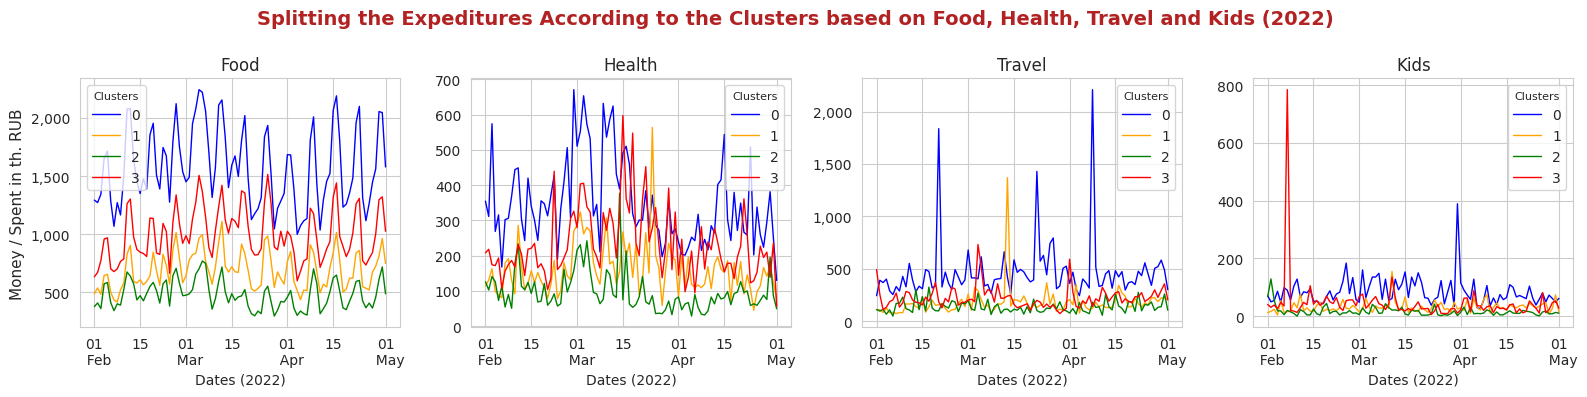

In [45]:
fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (16, 4))
ax = ax.flat
for i in range(0, 4, 1):
    if i == 0:
        sns.lineplot(data=food_clusters, y=food_clusters['Amount'].astype(float)/1e3, x=food_clusters['DateTime'], hue = food_clusters['clusters_2022_2021'], palette=pal, linewidth=1, ax = ax[i])

        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        sec.set_xlabel('Dates (2022)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='Clusters', loc='best') 
        ax[i].set_title('Food')
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('Money / Spent in th. RUB', fontsize=11) 

    elif i == 1:
        sns.lineplot(data=health_clusters, y=health_clusters['Amount'].astype(float)/1e3, x=health_clusters['DateTime'], hue = health_clusters['clusters_2022_2021'], palette=pal, linewidth=1, ax = ax[i])

        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        sec.set_xlabel('Dates (2022)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='Clusters', loc='best')
        ax[i].set_title('Health')
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')

    elif i == 2:
        sns.lineplot(data=travel_clusters, y=travel_clusters['Amount'].astype(float)/1e3, x=travel_clusters['DateTime'], hue = travel_clusters['clusters_2022_2021'], palette=pal, linewidth=1, ax = ax[i])


        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        sec.set_xlabel('Dates (2022)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='Clusters', loc='best')
        ax[i].set_title('Travel')
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')

    
    else: 
        sns.lineplot(data=kids_clusters, y=kids_clusters['Amount'].astype(float)/1e3, x=kids_clusters['DateTime'], hue = kids_clusters['clusters_2022_2021'], palette=pal, linewidth=1, ax = ax[i])


        ''' Multi level x-axis, multilevel (nested) ticks '''   # x=data['DateTime'].dt.strftime('%d')
        ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%d')) # just format the days
        sec = ax[i].secondary_xaxis(location = -0.085) # label the months:
        sec.xaxis.set_major_locator(mdates.MonthLocator(bymonth = range(1,13), bymonthday=1, interval=1, tz=None)) 
        # note the extra spaces in the label to align the month label inside the month, and note that this could have been done by changing 'bymonthday' above as well:
        sec.xaxis.set_major_formatter(mdates.DateFormatter('  %b'))
        sec.tick_params('x', length=0)
        sec.spines['bottom'].set_linewidth(0)
        sec.set_xlabel('Dates (2022)') # label the xaxis, but note for this to look good, it needs to be on the, secondary xaxis
        plt.setp(ax[i].get_legend().get_texts(), fontsize='6') 
        plt.setp(ax[i].get_legend().get_title(), fontsize='8') 
        sns.move_legend(ax[i], title='Clusters', loc='best')
        ax[i].set_title('Kids')
        ax[i].get_yaxis().set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
        ax[i].set_xlabel('')
        ax[i].set_ylabel('')
        
fig.suptitle('Splitting the Expeditures According to the Clusters based on Food, Health, Travel and Kids (2022)', fontsize = 14, fontweight = 'bold', color = 'firebrick', y = 0.995)
#plt.savefig('Splitting_the_expeditures_according_to_the_clusters_FHTK_2022.png', dpi=600, pad_inches=0.1, facecolor='white')
fig.tight_layout()
fig.show()

In [46]:
'''''''''    NOTES     ''''''''''''


pd.DataFrame(working_df.dtypes, columns = ['Column name','Data type'])

'''
working_df['amt'] = working_df['amt'].fillna(0)

for row in working_df.itertuples():
    if working_df.loc[row.Index, 'amt'].any() <= 0:
       working_df.at[row.Index, 'amt'] = 1

working_df.head(5)


# DataFrame groupby of multiple columns

car_types_by_origin = df.groupby(by=['Origin','Cylinders']).mean()
car_types_by_origin['Car Count'] = df.groupby(by=['Origin','Cylinders']).size()



---------------------------------------------------------------------------------------------------------------------------------------------


working_df.groupby( by = ['DateTime', 'TopCategory'], 
                    axis=0, 
                    level=None,
                    as_index=True, 
                    sort=True, 
                    group_keys=True, 
                    observed=False, 
                    dropna=True)['Amount'].sum().unstack()

'''both are the same'''

pd.pivot_table( working_df, 
                values="Amount",            # ["A", "B"]      
                index=pd.Grouper(freq="D", key="DateTime"), 
                columns="TopCategory", 
                aggfunc={"Amount": "sum"},  # {"A":"sum", "B":"mean"}
                fill_value=None, 
                margins=False, 
                dropna=True, 
                margins_name='All',  # Total
                observed=False, 
                sort=True
                )


# Filter data for specific weekday (tuesday) that is, posts on all Tuesdays: using the DateTimeIndex(dt)
filtered_df = df.loc[df['date'].dt.weekday == 2] 

---------------------------------------------------------------------------------------------------------------------------------------------

from sklearn.manifold import TSNE
model = TSNE(learning_rate='auto', init='pca', random_state=42)   
tsne_data = model.fit_transform(wdf_032020_032019)
plt.figure(figsize=(7, 7))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1])
plt.show()


from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)   
tsne_data = model.fit_transform(wdf_032020_032019)
plt.figure(figsize=(7, 7))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1])
plt.show()







---------------------------------------------------------------------------------------------------------------------------------------------

''' 

feature scaling: There are two most common techniques of how to scale columns of Pandas dataframe,


min-max normalization ~
                         the values are scaled in between the range of [n,m] where n is the minimum value and m is the maximum value


standardization ~
                    is a very important concept in feature scaling which is an integral part of feature engineering  
                    for this, we will commonly normalize or standardize the data
                    the process of scaling down the data and making it easier for the machine learning model to learn from it
                    in this method, reducing the mean to '0' and the standard deviation to '1'

'''

#scaler = MinMaxScaler(feature_range= (0.1, 9))

#scaler = StandardScaler() 
scaler = MinMaxScaler()

wdf_032020_032019[['survival']] = scaler.fit_transform(wdf_032020_032019[['survival']])
wdf_032020_032019[['socialization']] = scaler.fit_transform(wdf_032020_032019[['socialization']])
wdf_032020_032019[['self_realization']] = scaler.fit_transform(wdf_032020_032019[['self_realization']])
wdf_032020_032019[['money']] = scaler.fit_transform(wdf_032020_032019[['money']])


#wdf_032020_032019 = np.log10(wdf_032020_032019)


wdf_032020_032019








---------------------------------------------------------------------------------------------------------------------------------------------
'''
Bisecting K-means clustering 

'''

bkm = BisectingKMeans(n_clusters = 4, init = 'k-means++', max_iter = 100, random_state = 42, algorithm = 'lloyd',)

''' fitting the model to our dataset '''
bkm.fit_predict(wdf_032020_032019[['survival', 'socialization', 'self_realization', 'money']])

''' assigning new column to the wdf_032020_032019 dataframe''' 
wdf_032020_032019['clusters_2020_2019_bkm'] = bkm.labels_

# wdf_032020_032019

''' pd.DataFrame creates index by default '''

temp_bkm_2020_2019 = pd.DataFrame(wdf_032020_032019['clusters_2020_2019_bkm'].value_counts())

''' removing index from the temp_km_2020_2019 dataframe and renaming the colunms then sorting the dataframe '''

temp_bkm_2020_2019 = temp_bkm_2020_2019.reset_index() 

temp_bkm_2020_2019.rename(columns = {'index':'clusters_2020_2019_bkm', 'clusters_2020_2019_bkm':'number of clients in each cluster'}, inplace = True)

temp_bkm_2020_2019 = temp_bkm_2020_2019.sort_values(by = 'clusters_2020_2019_bkm', ascending = True)

temp_bkm_2020_2019
---------------------------------------------------------------------------------------------------------------------------------------------

ax = plt.gca()  # get current axis
xticks = ax.get_xticks() # get current xtick labels
ax.set_xticklabels([pd.to_datetime(tm, unit='ms').strftime('%d') for tm in xticks])


---------------------------------------------------------------------------------------------------------------------------------------------
''' 
trying to find difference between years to find out the varyings in clients' attitude
filtering data between two dates, as a result, acquire the subset of data, the filtered DataFrame

March 2019
'''

print(f'\n')
print('Filtered set of data rows based on period (2019-03-15 -- 2019-03-31) and scaled:') 

wdf_032019_pivoted = pd.pivot_table( working_df.loc[(working_df['DateTime'] >= '2019-03-15') & (working_df['DateTime'] <= '2019-03-31')],
                                     values='Amount',            # ['A', 'B']      
                                     index='Client', 
                                     columns='TopCategory', 
                                     aggfunc={'Amount': 'sum'},  # {'A':'sum', 'B':'mean'}
                                     fill_value=0, 
                                     margins=True, 
                                     dropna=True, 
                                     margins_name='total',  # All
                                     observed=False, 
                                     sort=True
                                    )

''' 
performing custom feature scaling
'''

for row in wdf_032019_pivoted.itertuples():
    wdf_032019_pivoted.at[row.Index, 'money'] = wdf_032019_pivoted.loc[row.Index, 'money'] / (wdf_032019_pivoted.loc[row.Index, 'total'])
    wdf_032019_pivoted.at[row.Index, 'self_realization'] = wdf_032019_pivoted.loc[row.Index, 'self_realization'] / (wdf_032019_pivoted.loc[row.Index, 'total'])  
    wdf_032019_pivoted.at[row.Index, 'socialization'] = wdf_032019_pivoted.loc[row.Index, 'socialization'] / (wdf_032019_pivoted.loc[row.Index, 'total'])  
    wdf_032019_pivoted.at[row.Index, 'survival'] = wdf_032019_pivoted.loc[row.Index, 'survival'] / (wdf_032019_pivoted.loc[row.Index, 'total']) 



''' it means all rows except last one and all columns except the last column '''
wdf_032019_pivoted = wdf_032019_pivoted.iloc[:-1, :-1]                


wdf_032019_pivoted
---------------------------------------------------------------------------------------------------------------------------------------------
''' 
trying to find difference between years to find out the varyings in clients' attitude
filtering data between two dates, as a result, acquire the subset of data, the filtered DataFrame

March 2020
'''

print(f'\n')
print('Filtered set of data rows based on date (2020-03-15 -- 2020-03-31) and scaled:') 

wdf_032020_pivoted = pd.pivot_table( working_df.loc[(working_df['DateTime'] >= '2020-03-15') & (working_df['DateTime'] <= '2020-03-31')],
                                     values='Amount',            # ['A', 'B']      
                                     index='Client', 
                                     columns='TopCategory', 
                                     aggfunc={'Amount': 'sum'},  # {'A':'sum', 'B':'mean'}
                                     fill_value=0, 
                                     margins=True, 
                                     dropna=True, 
                                     margins_name='total',  # All
                                     observed=False, 
                                     sort=True
                                    )


''' 
performing custom feature scaling
'''

for row in wdf_032020_pivoted.itertuples():
    wdf_032020_pivoted.at[row.Index, 'money'] = wdf_032020_pivoted.loc[row.Index, 'money'] / (wdf_032020_pivoted.loc[row.Index, 'total'])
    wdf_032020_pivoted.at[row.Index, 'self_realization'] = wdf_032020_pivoted.loc[row.Index, 'self_realization'] / (wdf_032020_pivoted.loc[row.Index, 'total'])  
    wdf_032020_pivoted.at[row.Index, 'socialization'] = wdf_032020_pivoted.loc[row.Index, 'socialization'] / (wdf_032020_pivoted.loc[row.Index, 'total'])  
    wdf_032020_pivoted.at[row.Index, 'survival'] = wdf_032020_pivoted.loc[row.Index, 'survival'] / (wdf_032020_pivoted.loc[row.Index, 'total']) 



''' it means all rows except last one and all columns except the last one '''
wdf_032020_pivoted = wdf_032020_pivoted.iloc[:-1, :-1]                


wdf_032020_pivoted
---------------------------------------------------------------------------------------------------------------------------------------------
colors=['darkblue', 'orange', 'darkgreen', 'magenta', 'cyan','red', 'pink']
grps=['survival', 'socialization', 'self_realization', 'money']
nclust=4
plt.figure(figsize=(12,3))
for i,j in enumerate(grps):
    c=j#+'_x'
    ax=plt.subplot(1,4,i+1)

    parts2 = ax.violinplot([wdf_merged_m1.loc[wdf_changed_clients.index,:].loc[(wdf_merged_m1.clusters_2020_2019==k)][c].values for k in range(nclust)], positions=np.arange(nclust), showmeans=True) #.loc[indinv,:]
    for pc in parts2['bodies']:
        pc.set_facecolor(colors[0])
        pc.set_edgecolor('black')
        pc.set_alpha(0.4)
        
    parts  = ax.violinplot([wdf_merged_m1.loc[wdf_unchanged_clients.index,:].loc[(wdf_merged_m1.clusters_2020_2019==k)][c].values    for k in range(nclust)], positions=np.arange(nclust), showmeans=True)
    for pc in parts['bodies']:
        pc.set_facecolor(colors[1])
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)
        
    plt.title(j.capitalize())    
    plt.xlabel('Cluster')
    plt.ylabel('Relative shift')
    plt.axhline(0., lw=1.5, c='black')
    #plt.ylim(-1.02, 1.02)
    plt.xticks(np.arange(nclust),np.arange(nclust)) 
    plt.grid(axis='y')
    if i==0:
        plt.scatter(None,None, c=colors[1], label='Strategy kept', alpha=0.7, lw=5)
        plt.scatter(None,None, c=colors[0], label='Strategy shifted', alpha=0.4, lw=5)
        plt.legend(loc=3)
plt.tight_layout()
#plt.savefig('clusters2022.png', dpi=600, pad_inches=0.1, facecolor='white')
plt.show()
---------------------------------------------------------------------------------------------------------------------------------------------
gr_by_client_survival = wdf_temp[(wdf_temp['Top Category'] == 'survival') & ((wdf_temp['DateTime'] >= '2020-02-01') & (wdf_temp['DateTime'] <= '2020-05-01'))].groupby(by = ['DateTime', 'clusters_2020_2019'], 
                                                                                  axis=0, 
                                                                                  level=None,
                                                                                  as_index=True, 
                                                                                  sort=True, 
                                                                                  group_keys=True, 
                                                                                  observed=False, 
                                                                                  dropna=True)['Amount'].sum()



temp = gr_by_client_survival.to_frame()
temp = temp.reset_index()
temp
---------------------------------------------------------------------------------------------------------------------------------------------
# smoothing process

from scipy.interpolate import make_interp_spline

X_Y_Spline = make_interp_spline(survival_clusters['DateTime'], (survival_clusters['Amount'].astype(float)/1e3)) 

# create integers from strings
idx = range(len(survival_clusters['DateTime']))
X_ = np.linspace(idx.min(), idx.max(), 500)
Y_ = X_Y_Spline(X_)

        
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------------



'''

SyntaxError: unterminated triple-quoted string literal (detected at line 350) (2374919776.py, line 350)

In [ ]:
'''  Notes

https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases 

Here, we want to drop the first row, which will require us to give 0 as an argument,
as well an axis value of 0, which indicates that a row is to be dropped:
'''
'''
working_df = working_df.drop(0, axis=0, inplace=True)
working_df = working_df.drop("SubCategory", axis=1, inplace=True)


dataframe.iloc[start_row : end_row , start_col : end_col]
The function iloc[1:3] would include the from 1. row upto 3. row and does not include the index 3
We use ':' to return all data i.e., to get all rows/columns
df.iloc[:, -1] it means all rows and the last column
df.iloc[:, :-1] it means all rows and until the last column

Single selections using iloc and DataFrame
Rows:
data.iloc[0] = first row of dataframe
data.iloc[1] = second row of dataframe
data.iloc[-1] = last row of dataframe
Columns:
data.iloc[:,0] = all rows and first column of dataframe
data.iloc[:,1] = all rows and second column of dataframe
data.iloc[:,-1] = all rows and last column of dataframe

x = np.array(df_br.iloc[:, 1:]) # it means all rows and starting from first column until the last column of data frame
y = np.array(df_br.iloc[:, 0])  # it means all rows and just first column of data frame


# temp = working_df[["Money"]]
# date_list = [datetime.datetime.strptime("2020-03-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
# future = pd.DataFrame(index=date_list, columns= temp.columns)
# temp = pd.concat([temp, future])

# temp["Predicted"] = invboxcox(best_model.predict(start=1250, end=1693), lmbda)

# plt.figure(figsize=(15, 5))
# plt.plot(temp["Money"].values, color="green")
# plt.plot(temp["Predicted"].values, color="red")
# plt.ticklabel_format(style='plain', axis='y')
# plt.grid(True)
# plt.title('Daily Total Expenses of Money Category', fontsize=10)
# plt.xlabel('Days (Whole Time Period)', fontsize=8)
# plt.ylabel('Money / Payment (RUR)', fontsize=8)
# plt.legend(("Time Series", "RNN Forecast"), shadow=True, loc='upper right', handlelength=1.5, fontsize=10)
# plt.show()

for row in working_df.itertuples():
    working_df.at[row.Index, 'Money'] = np.log2(working_df.loc[row.Index, 'Money'])

for row in working_df.itertuples():
  if mot_1 in working_df.loc[:, 'sentences'][row.Index]:
    count_mot_1 = count_mot_1 + 1

'''